In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
import tensorflow

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Flatten, Input, Conv2D, LSTM, GRU, BatchNormalization, MaxPooling2D, Reshape
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
from numpy.random import seed
seed(13)
tensorflow.random.set_seed(2)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive


drive.mount('/content/gdrive')
current_path = os.path.join(os.getcwd(), 'gdrive/MyDrive')
dataset_path = os.path.join(current_path,"speech_commands_v0_02_dataset")
path_save_downsampled = os.path.join(current_path, "speech_commands_data/downsampled_dataset")
path_save_small = os.path.join(current_path, "speech_commands_data/small_dataset")


path_save_small_logmelspectrogram = os.path.join(path_save_small, 'log_mel_spectrogram')


Mounted at /content/gdrive


In [ ]:
os.listdir(path_save_small_logmelspectrogram)

['Mal',
 'x_train_small_logmelspectrogram.pickle',
 'x_val_small_logmelspectrogram.pickle',
 'x_test_small_logmelspectrogram.pickle',
 'x_train_small_logmelspectrogram.np.npy',
 'x_val_small_logmelspectrogram.np.npy',
 'x_test_small_logmelspectrogram.np.npy',
 'x_train_small_logmelspectrogram_1.npy',
 'x_val_small_logmelspectrogram_1.npy',
 'x_test_small_logmelspectrogram_1.npy']

In [ ]:
def load_object(path_to_file):
  with open(path_to_file, "rb") as input_file:
    object = pickle.load(input_file)
  return object

def save_with_pickle(name_file, data, path_to_safe):
  with open(os.path.join(path_to_safe, name_file), "wb") as file:
      pickle.dump(data, file)

# Creation of classes

In [ ]:
small_train_label = load_object(os.path.join(path_save_small, 'cleaned_label_train_small.pickle'))
small_val_label = load_object(os.path.join(path_save_small, 'cleaned_label_val_small.pickle'))
small_test_label = load_object(os.path.join(path_save_small, 'cleaned_label_test_small.pickle'))

In [ ]:
commands_unkown_word = {"bed", "bird", "cat", "dog", "happy", "house", "marvin", "sheila", "tree", "wow"}
commands = np.unique(small_train_label)

In [ ]:

def assign_num_to_command(commands, commands_unkown_word):
  """Assigns a number to each command. Commands belonging to commands_unkown_word
  will be assigned the same number (the last one).

  :param commands: List of all commands, including the ones that belong to
  command_unkown_word.
  :param commands_unkown_word: List of commands that belong to unknown word class.
  :return: Dictionary that maps each class with a number.
  """
  commands_numerical = {}

  c = 0
  for command in commands:
    if command not in commands_unkown_word:
      commands_numerical[str(command)] = c
      c += 1
    else:
      commands_numerical[str(command)] = len(commands) - len(commands_unkown_word)
  return(commands_numerical)

def create_label_numerical_array(labels):
  """Returns an array that has replaced the classes in "labels" by their
  assigned numbers.
  :param labels: List of labels (classes) of instances.
  :return: Array with the labels replaced by the corresponding number.
  """
  commands_numerical = assign_num_to_command(commands, commands_unkown_word)

  y_array = np.array(labels, dtype=object)
  for command in commands:
    y_array = np.where(y_array == command, commands_numerical[str(command)], y_array)
  return y_array


In [ ]:
label_train = create_label_numerical_array(small_train_label)

n_classes = len(set(label_train))

# One-hot encoding
y_train = to_categorical(label_train, num_classes=n_classes)
y_val = to_categorical(create_label_numerical_array(small_val_label), num_classes=n_classes)
y_test = to_categorical(create_label_numerical_array(small_test_label), num_classes=n_classes)


In [ ]:
classes = set(commands) - set(commands_unkown_word)
classes = np.unique(list(classes))
classes = np.append(classes, 'unkown_word')

# Load data

In [ ]:
small_train_data = np.load(os.path.join(path_save_small_logmelspectrogram , 'x_train_small_logmelspectrogram.np.npy'))
small_val_data = np.load(os.path.join(path_save_small_logmelspectrogram , 'x_val_small_logmelspectrogram.np.npy'))
small_test_data = np.load(os.path.join(path_save_small_logmelspectrogram , 'x_test_small_logmelspectrogram.np.npy'))


In [ ]:
small_train_data.shape

(13050, 63, 64)

In [ ]:
# Normalize data
train_shape = np.array(small_train_data).shape

x_train_flattened = small_train_data.flatten()

scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(x_train_flattened.reshape(-1, 1))

x_train = x_train_normalized.reshape(train_shape)

def normalize_data(data, scaler):
  shape = data.shape
  data_flattened = data.flatten()
  data_normalized = scaler.transform(data_flattened.reshape(-1,1))
  return data_normalized.reshape(shape)


In [ ]:
x_train.shape

(13050, 63, 64)

In [ ]:
x_val = normalize_data(small_val_data, scaler)
x_test = normalize_data(small_test_data, scaler)

In [ ]:

input_shape = (63,64,1)

In [ ]:
input_shape

(63, 64, 1)

# Functions for evaluating model

In [ ]:
class MetricsInfoShower:
  """Class for showing reports and graphics regarding training and test
  evaluation."""

  def __init__(self, model, h_model, x, y_true, batch_size, classes) -> None:
    self.model = model
    self.h_model = h_model
    self.last_epoch = len(self.h_model.history['loss'])
    self.batch_size = batch_size
    self.y_true = np.argmax(y_test, axis=1)
    self.y_pred = self._get_y_pred(x)
    self.classes = classes



  def _get_y_pred(self, x):
    y_pred = self.model.predict(x, batch_size=self.batch_size)
    return y_pred.argmax(axis=1)

  def show_classification_report(self):
    # Evaluación del modelo
    print("[INFO]: Evaluando el modelo...")

    # Report
    print(classification_report(self.y_true, self.y_pred, target_names=self.classes))

  def show_confusion_matrix(self):
    # Calcula la matriz de confusión
    cm = confusion_matrix(self.y_true, self.y_pred, normalize='pred')

    # Crea un gráfico de matriz de confusión utilizando seaborn
    plt.figure(figsize = (16, 16))
    ax = sns.heatmap(cm, annot=True, cmap="PuBu", fmt=".2f", xticklabels=self.classes, yticklabels=classes, vmin = 0.1 )

    # Añade etiquetas y título
    plt.xlabel("Etiqueta Predicha")
    plt.ylabel("Etiqueta Real")
    plt.title("Matriz de Confusión")

    plt.show()

  def show_training_loss(self):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["loss"], label="train_loss")
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

  def show_training_accuracy(self):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

  def show_all(self):
    self.show_training_loss()
    self.show_training_accuracy()
    self.show_classification_report()
    self.show_confusion_matrix()

### Experimento_A_cnn_lme_0_00

In [ ]:
exp_a_cnn_lme_0_00 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_0_00.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x, verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_0_00.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_0_00.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 64
h_exp_a_cnn_lme_0_00 = exp_a_cnn_lme_0_00.fit(x_train, y_train,
                                              batch_size=batch_size, epochs=50,
                                              validation_data=(x_val, y_val),
                                              callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2013 - loss: 2.7780
Epoch 1: val_loss improved from inf to 1.71429, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.2019 - loss: 2.7757 - val_accuracy: 0.5072 - val_loss: 1.7143 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/50
200/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5782 - loss: 1.4241
Epoch 2: val_loss improved from 1.71429 to 1.27853, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5790 - loss: 1.4213 - val_accuracy: 0.6294 - val_loss: 1.2785 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/50
193/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7080 - loss: 0.9702
Epoch 3: val_loss improved from 1.27853 to 1.15292, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7090 - loss: 0.9669 - val_accuracy: 0.6657 - val_loss: 1.1529 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/50
193/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7859 - loss: 0.7107
Epoch 4: val_loss improved from 1.15292 to 1.13845, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7863 - loss: 0.7091 - val_accuracy: 0.6808 - val_loss: 1.1384 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/50
195/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8295 - loss: 0.5590
Epoch 5: val_loss improved from 1.13845 to 1.08537, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8300 - loss: 0.5576 - val_accuracy: 0.7004 - val_loss: 1.0854 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/50
195/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8755 - loss: 0.4220
Epoch 6: val_loss did not improve from 1.08537
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8756 - loss: 0.4214 - val_accuracy: 0.6936 - val_loss: 1.1318 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/50
193/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9024 - loss: 0.3350
Epoch 7: val_loss did not improve from 1.08537
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9026 - loss: 0.3344 - val_accuracy: 0.6860 - val_loss: 1.2085 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9252 - loss: 0

In [ ]:
exp_a_cnn_lme_0_00.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 61, 62, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 29, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,052,560 (19.27 MB)

 Trainable params: 1,684,186 (6.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,368,374 (12.85 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


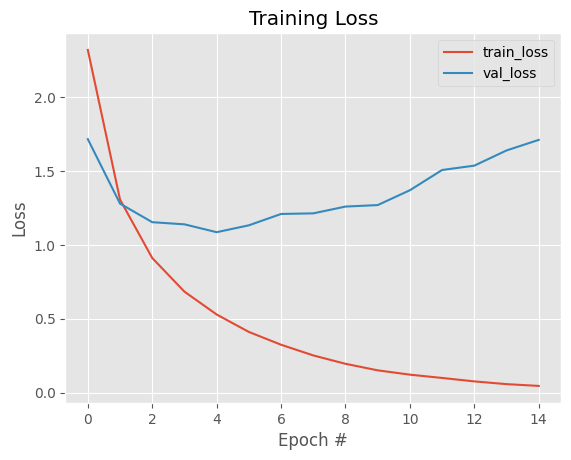

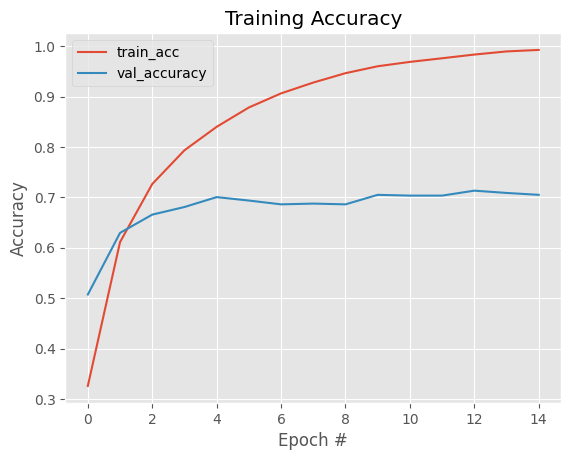

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.77      0.90      0.83        62
        down       0.76      0.68      0.72        62
       eight       0.82      0.87      0.84        62
        five       0.59      0.71      0.65        62
      follow       0.51      0.65      0.57        62
     forward       0.73      0.65      0.68        62
        four       0.64      0.63      0.63        62
          go       0.49      0.81      0.61        62
       learn       0.62      0.69      0.66        62
        left       0.79      0.66      0.72        62
        nine       0.79      0.77      0.78        62
          no       0.79      0.48      0.60        62
         off       0.78      0.65      0.71        62
          on       0.58      0.63      0.60        62
         one       0.92      0.73      0.81        62
       right       0.81      0.71      0.76        62
       seven       0.92      0.79      0.85       

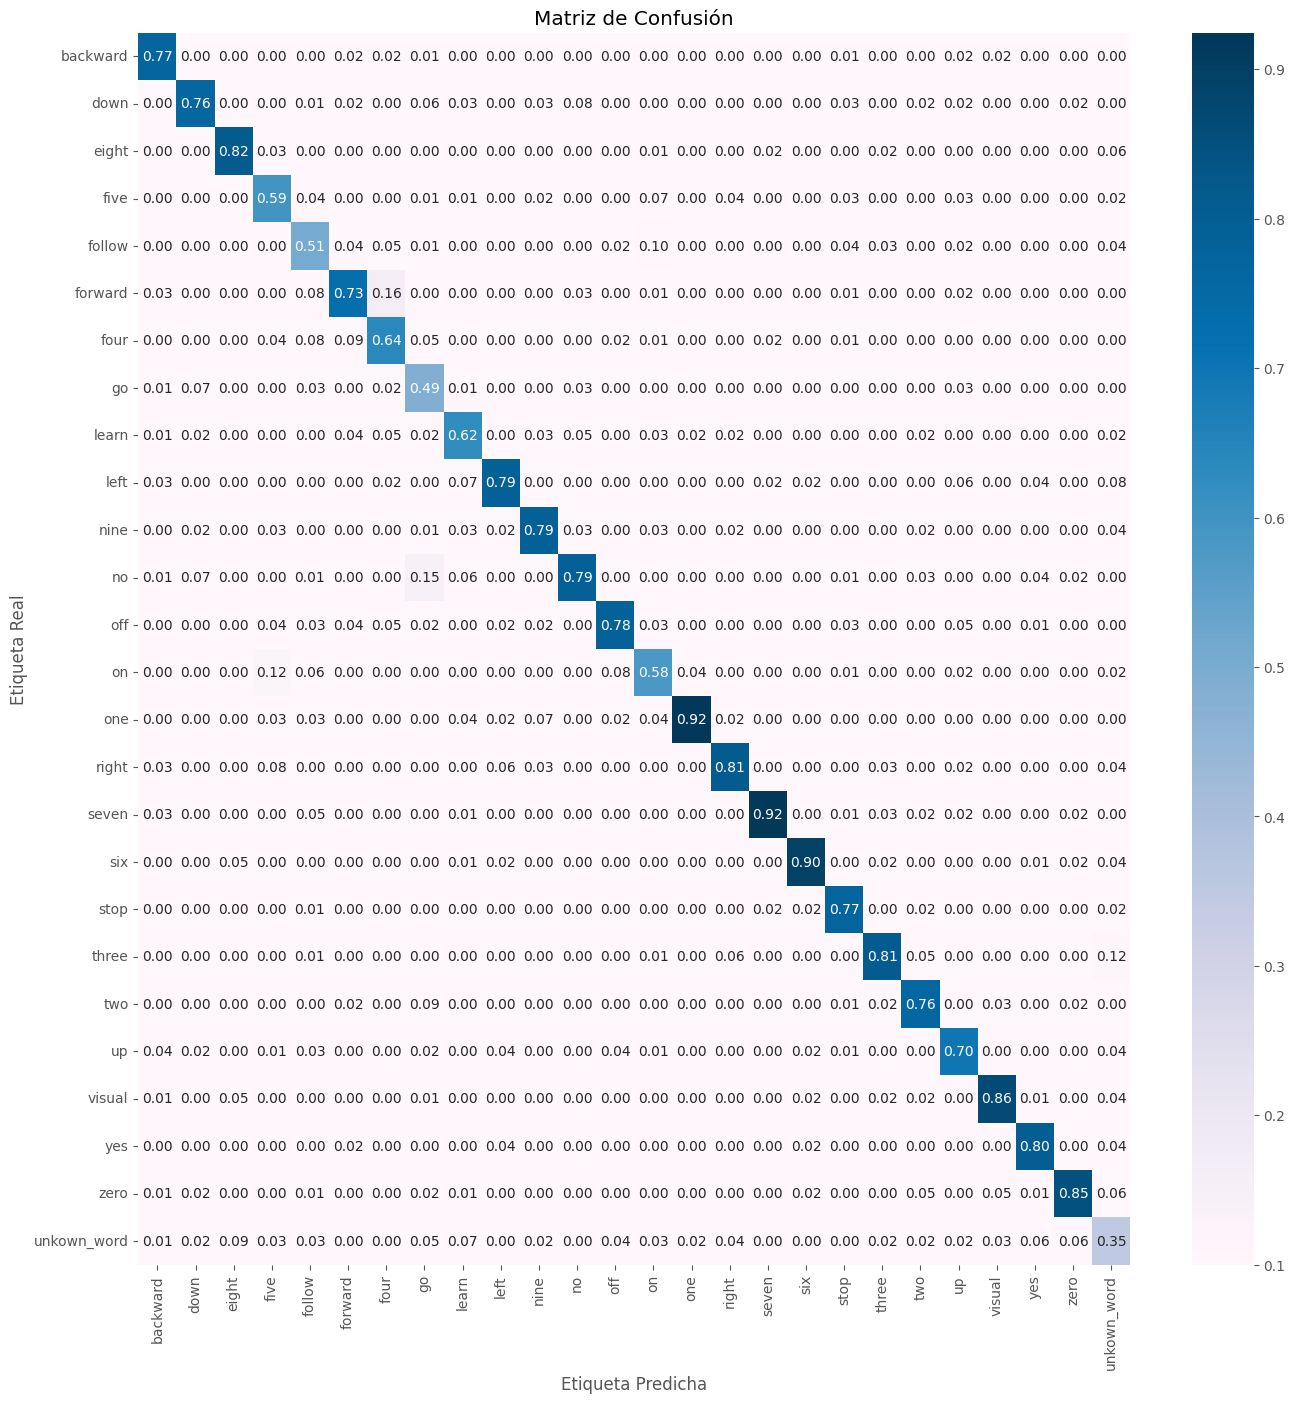

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_0_00, h_exp_a_cnn_lme_0_00, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_0_01

In [ ]:
exp_a_cnn_lme_0_01 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_0_01.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_0_01.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_0_01.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_0_01 = exp_a_cnn_lme_0_01.fit(x_train, y_train,
                                              batch_size=batch_size, epochs=90,
                                              validation_data=(x_val, y_val),
                                              callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1070 - loss: 3.4324
Epoch 1: val_loss improved from inf to 5.26114, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.1071 - loss: 3.4312 - val_accuracy: 0.0996 - val_loss: 5.2611 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3506 - loss: 2.0859
Epoch 2: val_loss improved from 5.26114 to 1.61121, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3528 - loss: 2.0790 - val_accuracy: 0.4974 - val_loss: 1.6112 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5852 - loss: 1.2944
Epoch 3: val_loss did not improve from 1.61121
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5856 - loss: 1.2934 - val_accuracy: 0.4294 - val_loss: 2.0073 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7223 - loss: 0.8611
Epoch 4: val_loss improved from 1.61121 to 1.17790, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7229 - loss: 0.8594 - val_accuracy: 0.6438 - val_loss: 1.1779 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8145 - loss: 0.5975
Epoch 5: val_loss improved from 1.17790 to 1.05776, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8149 - loss: 0.5960 - val_accuracy: 0.6989 - val_loss: 1.0578 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8838 - loss: 0.3927
Epoch 6: val_loss improved from 1.05776 to 1.05244, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8841 - loss: 0.3916 - val_accuracy: 0.7072 - val_loss: 1.0524 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9209 - loss: 0.2640
Epoch 7: val_loss did not improve from 1.05244
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9210 - loss: 0.2638 - val_accuracy: 0.7253 - val_loss: 1.0703 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9515 - loss: 0.1767
Epoch 8: val_loss did not improve from 1.05244
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9515 - loss: 0.1765 - val_accuracy: 0.7185 - val_loss: 1.1440 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.968

In [ ]:
exp_a_cnn_lme_0_01.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 61, 62, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 61, 62, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 29, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,054,096 (19.28 MB)

 Trainable params: 1,684,570 (6.43 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 3,369,142 (12.85 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


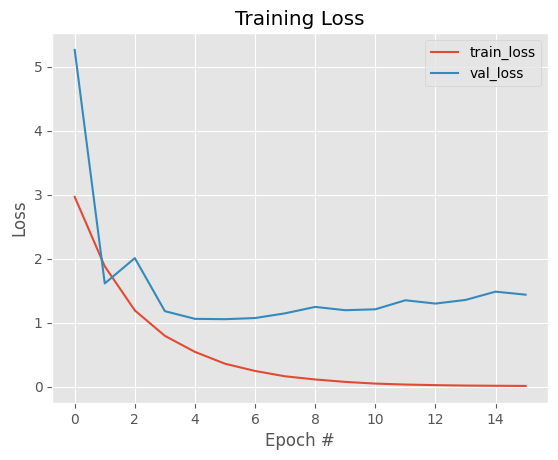

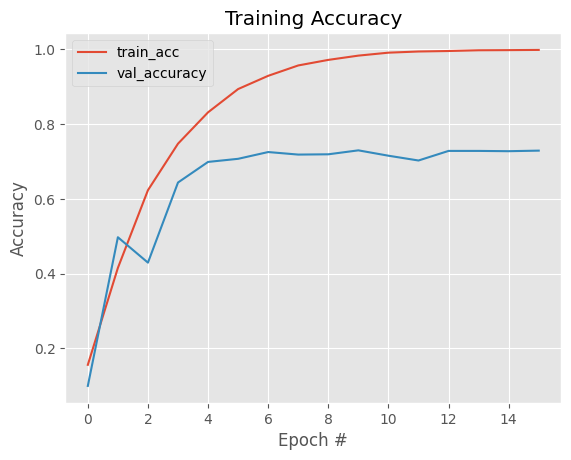

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.80      0.92      0.86        62
        down       0.86      0.68      0.76        62
       eight       0.82      0.85      0.83        62
        five       0.84      0.74      0.79        62
      follow       0.71      0.63      0.67        62
     forward       0.67      0.77      0.72        62
        four       0.68      0.58      0.63        62
          go       0.69      0.71      0.70        62
       learn       0.70      0.68      0.69        62
        left       0.83      0.81      0.82        62
        nine       0.78      0.94      0.85        62
          no       0.66      0.76      0.71        62
         off       0.78      0.73      0.75        62
          on       0.74      0.81      0.77        62
         one       0.71      0.85      0.77        62
       right       0.83      0.92      0.87        62
       seven       0.90      0.76      0.82       

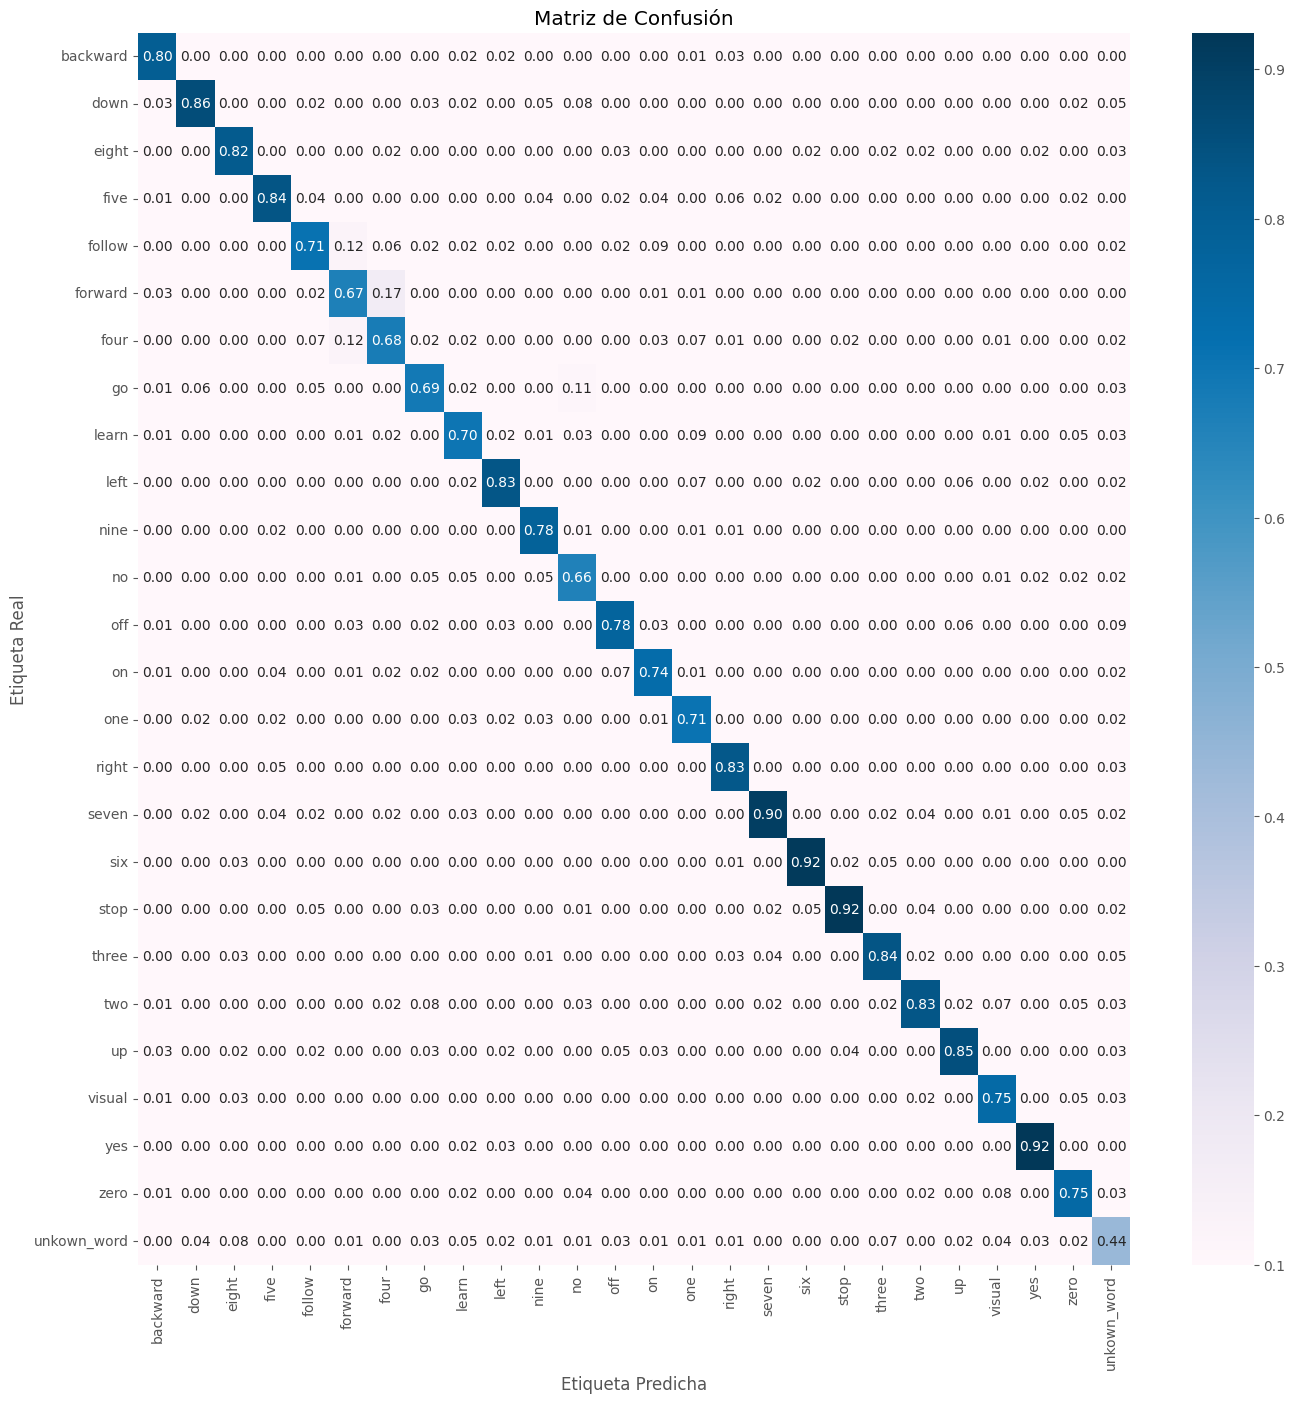

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_0_01, h_exp_a_cnn_lme_0_01, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_0_02

In [ ]:
exp_a_cnn_lme_0_02 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    # Capa de salida
    Dense(n_classes, activation='softmax')])

exp_a_cnn_lme_0_02.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_0_02.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_0_02.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_0_02 = exp_a_cnn_lme_0_02.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0509 - loss: 3.4687
Epoch 1: val_loss improved from inf to 5.78662, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.0510 - loss: 3.4682 - val_accuracy: 0.0581 - val_loss: 5.7866 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0968 - loss: 3.0586
Epoch 2: val_loss improved from 5.78662 to 2.86654, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0969 - loss: 3.0582 - val_accuracy: 0.1426 - val_loss: 2.8665 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1319 - loss: 2.8942
Epoch 3: val_loss improved from 2.86654 to 2.84622, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1321 - loss: 2.8936 - val_accuracy: 0.1721 - val_loss: 2.8462 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1647 - loss: 2.7488
Epoch 4: val_loss improved from 2.84622 to 2.55279, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1649 - loss: 2.7482 - val_accuracy: 0.2460 - val_loss: 2.5528 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2005 - loss: 2.6193
Epoch 5: val_loss improved from 2.55279 to 2.39382, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2007 - loss: 2.6189 - val_accuracy: 0.2830 - val_loss: 2.3938 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2472 - loss: 2.4616
Epoch 6: val_loss improved from 2.39382 to 2.16753, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2473 - loss: 2.4609 - val_accuracy: 0.3487 - val_loss: 2.1675 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2864 - loss: 2.3050
Epoch 7: val_loss improved from 2.16753 to 2.11313, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2867 - loss: 2.3045 - val_accuracy: 0.3675 - val_loss: 2.1131 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3223 - loss: 2.1748
Epoch 8: val_loss improved from 2.11313 to 1.89207, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3224 - loss: 2.1746 - val_accuracy: 0.4536 - val_loss: 1.8921 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3721 - loss: 2.0481
Epoch 9: val_loss improved from 1.89207 to 1.76333, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3719 - loss: 2.0478 - val_accuracy: 0.4936 - val_loss: 1.7633 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3860 - loss: 1.9532
Epoch 10: val_loss improved from 1.76333 to 1.67790, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3861 - loss: 1.9526 - val_accuracy: 0.5094 - val_loss: 1.6779 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4153 - loss: 1.8675
Epoch 11: val_loss improved from 1.67790 to 1.62970, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4153 - loss: 1.8675 - val_accuracy: 0.5306 - val_loss: 1.6297 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4422 - loss: 1.7730
Epoch 12: val_loss improved from 1.62970 to 1.57675, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4422 - loss: 1.7730 - val_accuracy: 0.5434 - val_loss: 1.5767 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4586 - loss: 1.7104
Epoch 13: val_loss improved from 1.57675 to 1.48217, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4586 - loss: 1.7105 - val_accuracy: 0.5645 - val_loss: 1.4822 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4731 - loss: 1.6522
Epoch 14: val_loss improved from 1.48217 to 1.42992, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4731 - loss: 1.6519 - val_accuracy: 0.5834 - val_loss: 1.4299 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4979 - loss: 1.5731
Epoch 15: val_loss improved from 1.42992 to 1.38855, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4979 - loss: 1.5731 - val_accuracy: 0.5970 - val_loss: 1.3885 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5106 - loss: 1.5202
Epoch 16: val_loss improved from 1.38855 to 1.34749, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5105 - loss: 1.5201 - val_accuracy: 0.6219 - val_loss: 1.3475 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5213 - loss: 1.4913
Epoch 17: val_loss improved from 1.34749 to 1.32474, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5212 - loss: 1.4913 - val_accuracy: 0.6174 - val_loss: 1.3247 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5276 - loss: 1.4535
Epoch 18: val_loss did not improve from 1.32474
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5276 - loss: 1.4535 - val_accuracy: 0.6068 - val_loss: 1.3486 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5539 - loss: 1.3819
Epoch 19: val_loss improved from 1.32474 to 1.25772, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5538 - loss: 1.3819 - val_accuracy: 0.6347 - val_loss: 1.2577 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5510 - loss: 1.3601
Epoch 20: val_loss improved from 1.25772 to 1.25727, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5512 - loss: 1.3599 - val_accuracy: 0.6453 - val_loss: 1.2573 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5744 - loss: 1.3008
Epoch 21: val_loss improved from 1.25727 to 1.18770, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5745 - loss: 1.3007 - val_accuracy: 0.6664 - val_loss: 1.1877 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5939 - loss: 1.2760
Epoch 22: val_loss did not improve from 1.18770
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5939 - loss: 1.2758 - val_accuracy: 0.6709 - val_loss: 1.2020 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5940 - loss: 1.2428
Epoch 23: val_loss did not improve from 1.18770
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5942 - loss: 1.2421 - val_accuracy: 0.6649 - val_loss: 1.1884 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6164 - loss: 1.1910 - val_accuracy: 0.6815 - val_loss: 1.1451 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6181 - loss: 1.1759
Epoch 25: val_loss improved from 1.14514 to 1.14356, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6181 - loss: 1.1758 - val_accuracy: 0.6891 - val_loss: 1.1436 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6298 - loss: 1.1659
Epoch 26: val_loss improved from 1.14356 to 1.13016, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6297 - loss: 1.1660 - val_accuracy: 0.6921 - val_loss: 1.1302 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6448 - loss: 1.1086
Epoch 27: val_loss improved from 1.13016 to 1.12326, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6446 - loss: 1.1088 - val_accuracy: 0.6883 - val_loss: 1.1233 - learning_rate: 6.4611e-05

Epoch 28: LearningRateScheduler setting learning rate to 5.8149737003040094e-05.
Epoch 28/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6382 - loss: 1.1149
Epoch 28: val_loss improved from 1.12326 to 1.11412, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6382 - loss: 1.1147 - val_accuracy: 0.6838 - val_loss: 1.1141 - learning_rate: 5.8150e-05

Epoch 29: LearningRateScheduler setting learning rate to 5.233476330273609e-05.
Epoch 29/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6443 - loss: 1.0948
Epoch 29: val_loss did not improve from 1.11412
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6442 - loss: 1.0948 - val_accuracy: 0.6928 - val_loss: 1.1169 - learning_rate: 5.2335e-05

Epoch 30: LearningRateScheduler setting learning rate to 4.7101286972462485e-05.
Epoch 30/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6485 - loss: 1.0764
Epoch 30: val_loss did not improve from 1.11412
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6486 - loss: 1.0761 - val_accuracy: 0.6898 - val_loss: 1.1237 - learning_rate: 4.7101e-05

Epoch 31: LearningRateScheduler setting learning rate to 4.239115827521624e-05.
Epoch 31/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6618 - loss: 1.0465 - val_accuracy: 0.6921 - val_loss: 1.1084 - learning_rate: 4.2391e-05

Epoch 32: LearningRateScheduler setting learning rate to 3.8152042447694614e-05.
Epoch 32/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6613 - loss: 1.0508
Epoch 32: val_loss improved from 1.10838 to 1.08964, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6613 - loss: 1.0505 - val_accuracy: 0.7042 - val_loss: 1.0896 - learning_rate: 3.8152e-05

Epoch 33: LearningRateScheduler setting learning rate to 3.433683820292515e-05.
Epoch 33/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6624 - loss: 1.0413
Epoch 33: val_loss did not improve from 1.08964
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6624 - loss: 1.0410 - val_accuracy: 0.6928 - val_loss: 1.1021 - learning_rate: 3.4337e-05

Epoch 34: LearningRateScheduler setting learning rate to 3.090315438263264e-05.
Epoch 34/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6775 - loss: 1.0130
Epoch 34: val_loss did not improve from 1.08964
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6775 - loss: 1.0130 - val_accuracy: 0.6928 - val_loss: 1.1057 - learning_rate: 3.0903e-05

Epoch 35: LearningRateScheduler setting learning rate to 2.7812838944369376e-05.
Epoch 35/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6742 - loss: 0.9993 - val_accuracy: 0.6936 - val_loss: 1.0842 - learning_rate: 2.7813e-05

Epoch 36: LearningRateScheduler setting learning rate to 2.5031555049932436e-05.
Epoch 36/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6790 - loss: 0.9885
Epoch 36: val_loss improved from 1.08416 to 1.08083, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6790 - loss: 0.9883 - val_accuracy: 0.6951 - val_loss: 1.0808 - learning_rate: 2.5032e-05

Epoch 37: LearningRateScheduler setting learning rate to 2.2528399544939195e-05.
Epoch 37/90
394/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6747 - loss: 0.9772
Epoch 37: val_loss improved from 1.08083 to 1.07744, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6746 - loss: 0.9776 - val_accuracy: 0.6974 - val_loss: 1.0774 - learning_rate: 2.2528e-05

Epoch 38: LearningRateScheduler setting learning rate to 2.0275559590445276e-05.
Epoch 38/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6876 - loss: 0.9727
Epoch 38: val_loss did not improve from 1.07744
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6875 - loss: 0.9728 - val_accuracy: 0.6928 - val_loss: 1.0805 - learning_rate: 2.0276e-05

Epoch 39: LearningRateScheduler setting learning rate to 1.824800363140075e-05.
Epoch 39/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6814 - loss: 0.9786
Epoch 39: val_loss improved from 1.07744 to 1.07303, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6814 - loss: 0.9784 - val_accuracy: 0.6943 - val_loss: 1.0730 - learning_rate: 1.8248e-05

Epoch 40: LearningRateScheduler setting learning rate to 1.6423203268260675e-05.
Epoch 40/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6898 - loss: 0.9672
Epoch 40: val_loss did not improve from 1.07303
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6896 - loss: 0.9672 - val_accuracy: 0.6921 - val_loss: 1.0755 - learning_rate: 1.6423e-05

Epoch 41: LearningRateScheduler setting learning rate to 1.4780882941434608e-05.
Epoch 41/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6865 - loss: 0.9646
Epoch 41: val_loss did not improve from 1.07303
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6865 - loss: 0.9646 - val_accuracy: 0.6974 - val_loss: 1.0840 - learning_rate: 1.4781e-05

Epoch 42: LearningRateScheduler setting learning rate to 1.3302794647291146e-05.
Epoch 42/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6969 - loss: 0.9349 - val_accuracy: 0.7011 - val_loss: 1.0714 - learning_rate: 8.7280e-06

Epoch 47: LearningRateScheduler setting learning rate to 7.85516721127895e-06.
Epoch 47/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6964 - loss: 0.9493
Epoch 47: val_loss did not improve from 1.07140
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6964 - loss: 0.9493 - val_accuracy: 0.6981 - val_loss: 1.0789 - learning_rate: 7.8552e-06

Epoch 48: LearningRateScheduler setting learning rate to 7.069650490151056e-06.
Epoch 48/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6916 - loss: 0.9644
Epoch 48: val_loss improved from 1.07140 to 1.06721, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6916 - loss: 0.9640 - val_accuracy: 0.6974 - val_loss: 1.0672 - learning_rate: 7.0697e-06

Epoch 49: LearningRateScheduler setting learning rate to 6.36268544113595e-06.
Epoch 49/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7074 - loss: 0.9139
Epoch 49: val_loss improved from 1.06721 to 1.06629, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7074 - loss: 0.9140 - val_accuracy: 0.6996 - val_loss: 1.0663 - learning_rate: 6.3627e-06

Epoch 50: LearningRateScheduler setting learning rate to 5.726416897022355e-06.
Epoch 50/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6986 - loss: 0.9394
Epoch 50: val_loss did not improve from 1.06629
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6986 - loss: 0.9394 - val_accuracy: 0.7004 - val_loss: 1.0685 - learning_rate: 5.7264e-06

Epoch 51: LearningRateScheduler setting learning rate to 5.15377520732012e-06.
Epoch 51/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6924 - loss: 0.9345
Epoch 51: val_loss did not improve from 1.06629
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6924 - loss: 0.9345 - val_accuracy: 0.7004 - val_loss: 1.0666 - learning_rate: 5.1538e-06

Epoch 52: LearningRateScheduler setting learning rate to 4.638397686588108e-06.
Epoch 52/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

In [ ]:
exp_a_cnn_lme_0_02.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 61, 62, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 61, 62, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 29, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,073,872 (19.36 MB)

 Trainable params: 1,691,162 (6.45 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 3,382,326 (12.90 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


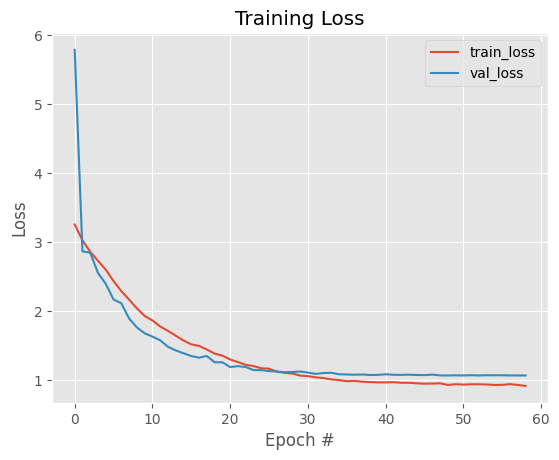

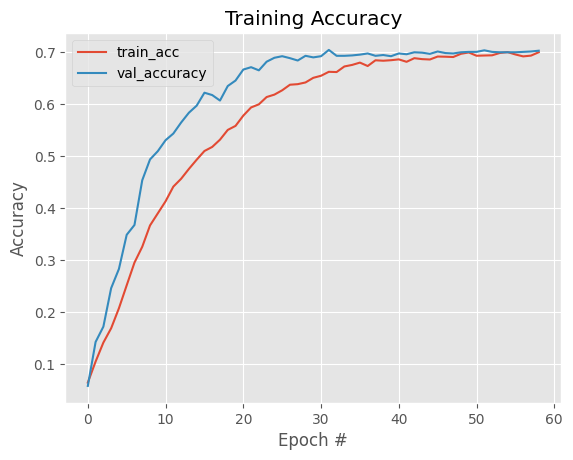

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.95      0.85      0.90        62
        down       0.65      0.71      0.68        62
       eight       0.74      0.81      0.77        62
        five       0.65      0.85      0.74        62
      follow       0.43      0.47      0.45        62
     forward       0.55      0.55      0.55        62
        four       0.54      0.35      0.43        62
          go       0.58      0.71      0.64        62
       learn       0.73      0.66      0.69        62
        left       0.86      0.77      0.81        62
        nine       0.80      0.89      0.84        62
          no       0.71      0.68      0.69        62
         off       0.81      0.56      0.67        62
          on       0.69      0.61      0.65        62
         one       0.71      0.82      0.76        62
       right       0.85      0.76      0.80        62
       seven       0.80      0.79      0.80       

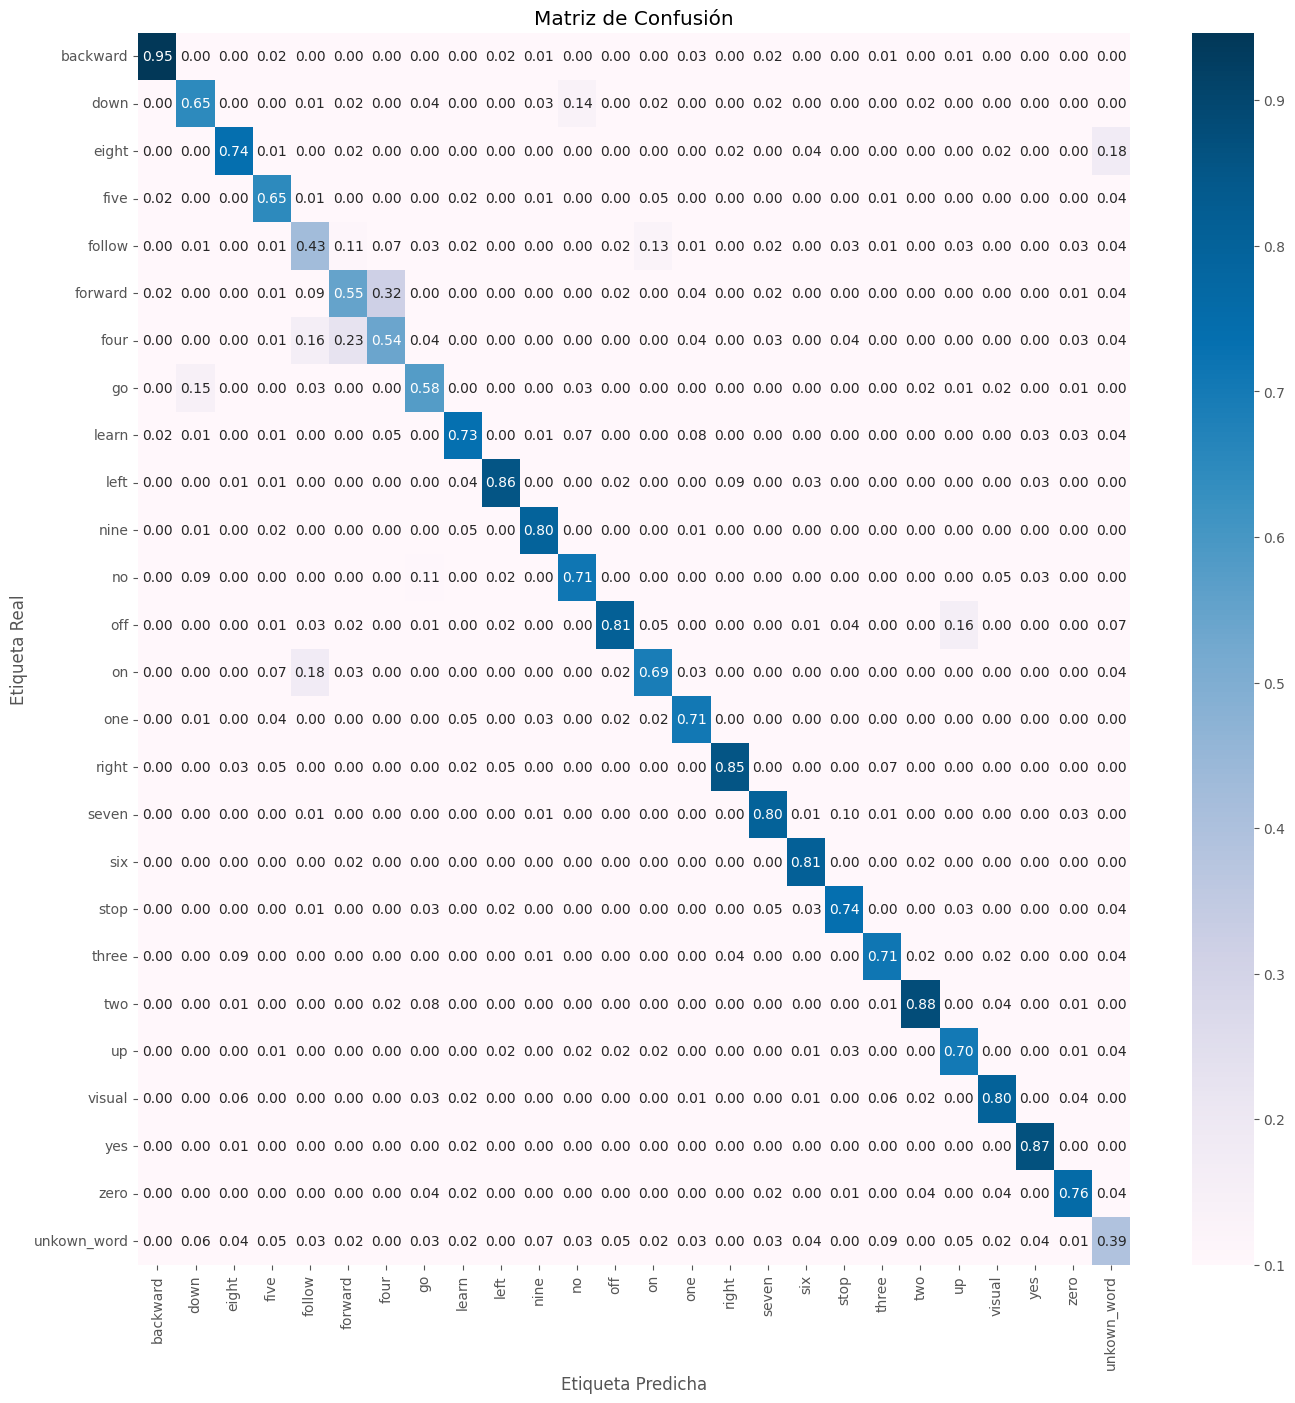

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_0_02, h_exp_a_cnn_lme_0_02, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_0_03

In [ ]:
exp_a_cnn_lme_0_03 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_0_03.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_0_03.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_0_03.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_0_03 = exp_a_cnn_lme_0_03.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0981 - loss: 3.0568
Epoch 1: val_loss improved from inf to 1.84006, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.0983 - loss: 3.0560 - val_accuracy: 0.4589 - val_loss: 1.8401 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4189 - loss: 1.8590
Epoch 2: val_loss improved from 1.84006 to 1.21286, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4191 - loss: 1.8583 - val_accuracy: 0.6249 - val_loss: 1.2129 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5668 - loss: 1.3611
Epoch 3: val_loss improved from 1.21286 to 0.99475, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5673 - loss: 1.3596 - val_accuracy: 0.6981 - val_loss: 0.9947 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6518 - loss: 1.0912
Epoch 4: val_loss improved from 0.99475 to 0.82705, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6521 - loss: 1.0906 - val_accuracy: 0.7426 - val_loss: 0.8271 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6982 - loss: 0.9245
Epoch 5: val_loss improved from 0.82705 to 0.79720, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6984 - loss: 0.9238 - val_accuracy: 0.7449 - val_loss: 0.7972 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7340 - loss: 0.8345
Epoch 6: val_loss improved from 0.79720 to 0.73111, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7341 - loss: 0.8340 - val_accuracy: 0.7804 - val_loss: 0.7311 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7595 - loss: 0.7573
Epoch 7: val_loss improved from 0.73111 to 0.66825, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7595 - loss: 0.7572 - val_accuracy: 0.7872 - val_loss: 0.6682 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7828 - loss: 0.6867
Epoch 8: val_loss improved from 0.66825 to 0.65849, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7828 - loss: 0.6861 - val_accuracy: 0.7955 - val_loss: 0.6585 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7937 - loss: 0.6106
Epoch 9: val_loss improved from 0.65849 to 0.65179, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7939 - loss: 0.6104 - val_accuracy: 0.8008 - val_loss: 0.6518 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8104 - loss: 0.5818
Epoch 10: val_loss improved from 0.65179 to 0.63191, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8105 - loss: 0.5815 - val_accuracy: 0.7955 - val_loss: 0.6319 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8249 - loss: 0.5452
Epoch 11: val_loss did not improve from 0.63191
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8250 - loss: 0.5447 - val_accuracy: 0.7955 - val_loss: 0.6387 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8332 - loss: 0.5013
Epoch 12: val_loss did not improve from 0.63191
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8333 - loss: 0.5011 - val_accuracy: 0.7955 - val_loss: 0.6501 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8469 - loss: 0.4690 - val_accuracy: 0.8083 - val_loss: 0.6294 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8519 - loss: 0.4559
Epoch 14: val_loss did not improve from 0.62945
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8521 - loss: 0.4553 - val_accuracy: 0.8030 - val_loss: 0.6402 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8628 - loss: 0.4137
Epoch 15: val_loss did not improve from 0.62945
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8628 - loss: 0.4137 - val_accuracy: 0.8091 - val_loss: 0.6477 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

In [ ]:
exp_a_cnn_lme_0_03.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 61, 62, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 29, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 753,200 (2.87 MB)

 Trainable params: 251,066 (980.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 502,134 (1.92 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


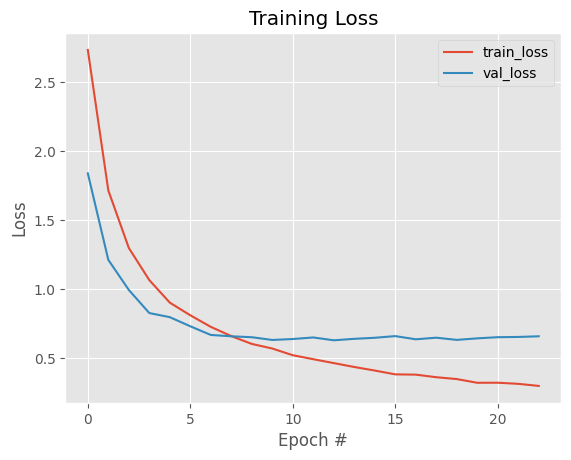

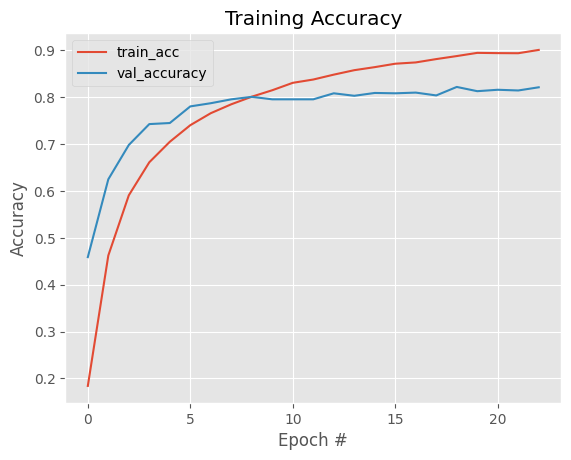

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.88      0.85      0.87        62
        down       0.88      0.71      0.79        62
       eight       0.84      0.92      0.88        62
        five       0.82      0.76      0.79        62
      follow       0.67      0.73      0.70        62
     forward       0.71      0.79      0.75        62
        four       0.78      0.68      0.72        62
          go       0.67      0.76      0.71        62
       learn       0.82      0.68      0.74        62
        left       0.95      0.87      0.91        62
        nine       0.90      0.92      0.91        62
          no       0.65      0.82      0.72        62
         off       0.91      0.84      0.87        62
          on       0.75      0.82      0.78        62
         one       0.81      0.84      0.83        62
       right       0.93      0.87      0.90        62
       seven       0.86      0.82      0.84       

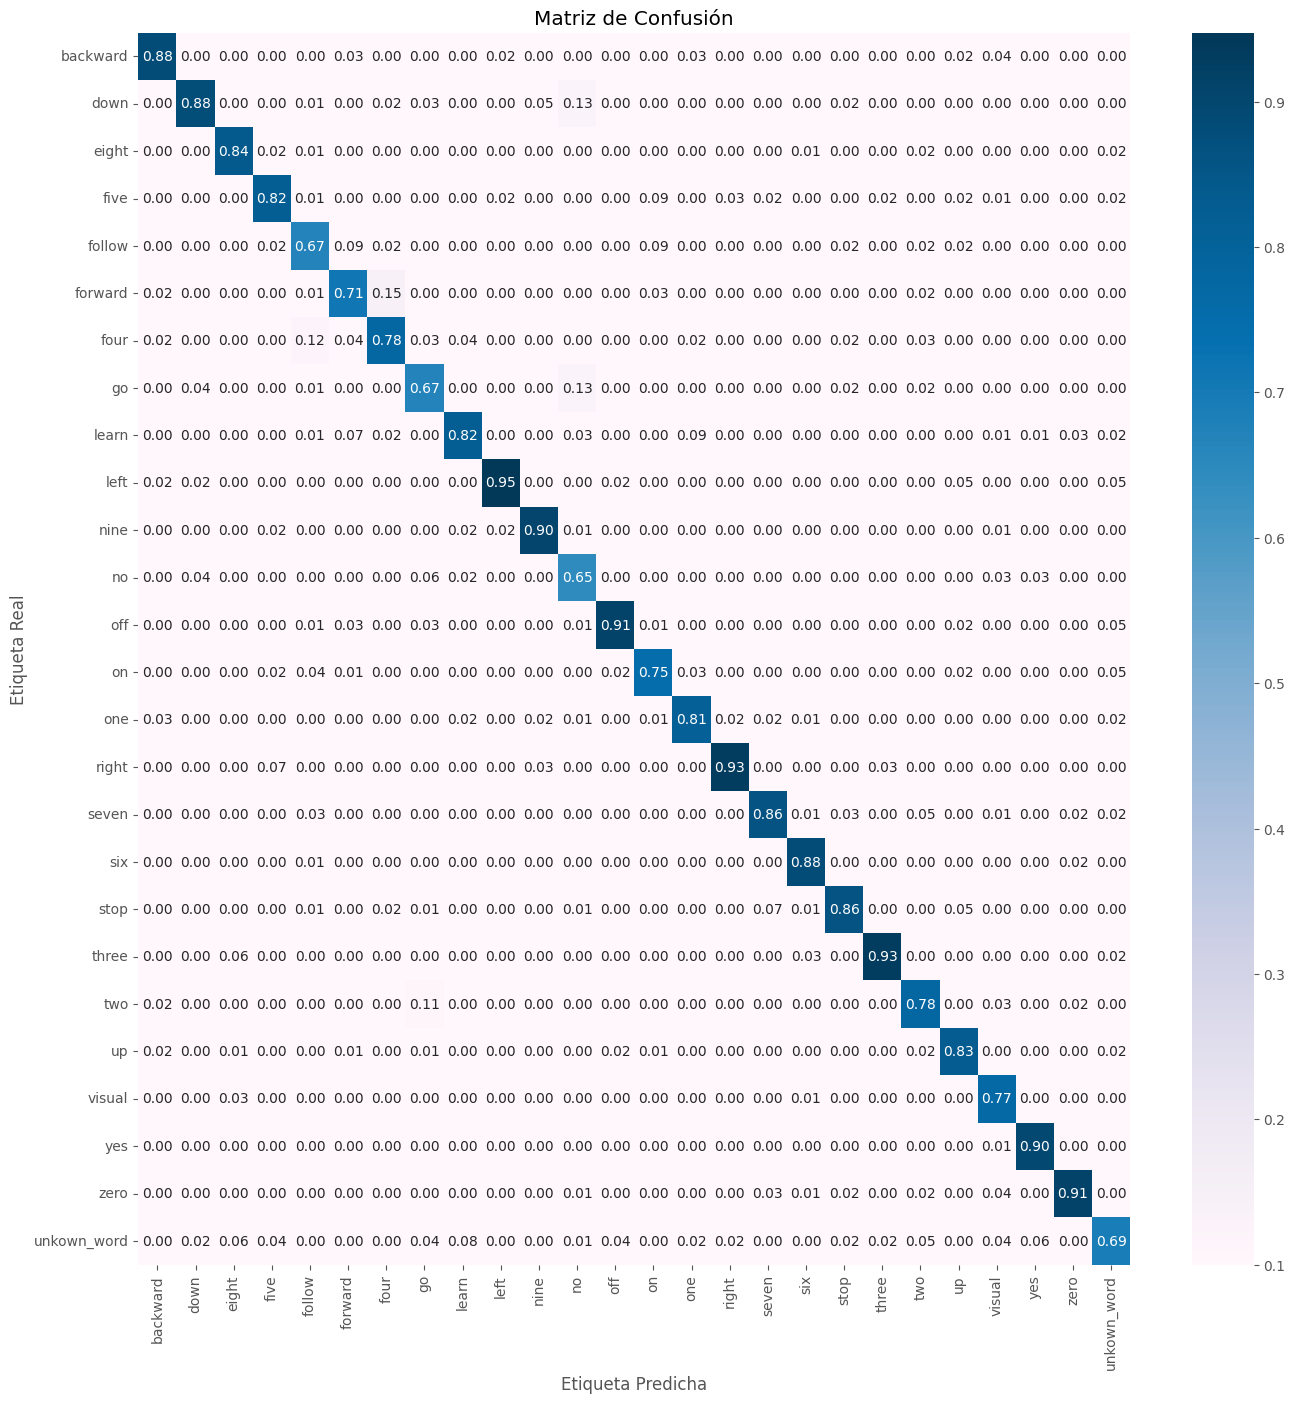

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_0_03, h_exp_a_cnn_lme_0_03, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_0_04

In [ ]:
exp_a_cnn_lme_0_04 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.3),
    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_0_04.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_0_04.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_0_04.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_0_04 = exp_a_cnn_lme_0_04.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1059 - loss: 3.0411
Epoch 1: val_loss improved from inf to 1.89231, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.1061 - loss: 3.0403 - val_accuracy: 0.4853 - val_loss: 1.8923 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4274 - loss: 1.8834
Epoch 2: val_loss improved from 1.89231 to 1.28308, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4279 - loss: 1.8816 - val_accuracy: 0.6219 - val_loss: 1.2831 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5560 - loss: 1.4122
Epoch 3: val_loss improved from 1.28308 to 1.01783, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5566 - loss: 1.4105 - val_accuracy: 0.6966 - val_loss: 1.0178 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6435 - loss: 1.1543
Epoch 4: val_loss improved from 1.01783 to 0.86249, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6436 - loss: 1.1535 - val_accuracy: 0.7442 - val_loss: 0.8625 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6821 - loss: 0.9880
Epoch 5: val_loss improved from 0.86249 to 0.81501, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6822 - loss: 0.9880 - val_accuracy: 0.7547 - val_loss: 0.8150 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
394/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7128 - loss: 0.8985
Epoch 6: val_loss improved from 0.81501 to 0.70778, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7129 - loss: 0.8984 - val_accuracy: 0.7728 - val_loss: 0.7078 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7418 - loss: 0.8054
Epoch 7: val_loss improved from 0.70778 to 0.68910, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7418 - loss: 0.8055 - val_accuracy: 0.7721 - val_loss: 0.6891 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7528 - loss: 0.7728
Epoch 8: val_loss improved from 0.68910 to 0.64846, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7528 - loss: 0.7725 - val_accuracy: 0.7872 - val_loss: 0.6485 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
394/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7670 - loss: 0.7272
Epoch 9: val_loss improved from 0.64846 to 0.61739, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7669 - loss: 0.7270 - val_accuracy: 0.8023 - val_loss: 0.6174 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7820 - loss: 0.6689
Epoch 10: val_loss improved from 0.61739 to 0.59725, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7820 - loss: 0.6689 - val_accuracy: 0.8008 - val_loss: 0.5973 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7910 - loss: 0.6473
Epoch 11: val_loss improved from 0.59725 to 0.57962, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7910 - loss: 0.6471 - val_accuracy: 0.8174 - val_loss: 0.5796 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7934 - loss: 0.6325
Epoch 12: val_loss improved from 0.57962 to 0.57031, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7935 - loss: 0.6323 - val_accuracy: 0.8091 - val_loss: 0.5703 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8075 - loss: 0.5914
Epoch 13: val_loss did not improve from 0.57031
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8076 - loss: 0.5912 - val_accuracy: 0.8075 - val_loss: 0.5710 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8184 - loss: 0.5694
Epoch 14: val_loss improved from 0.57031 to 0.56051, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8183 - loss: 0.5695 - val_accuracy: 0.8121 - val_loss: 0.5605 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8190 - loss: 0.5545
Epoch 15: val_loss improved from 0.56051 to 0.55728, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8190 - loss: 0.5547 - val_accuracy: 0.8211 - val_loss: 0.5573 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8333 - loss: 0.5254
Epoch 16: val_loss did not improve from 0.55728
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8331 - loss: 0.5253 - val_accuracy: 0.8204 - val_loss: 0.5587 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8322 - loss: 0.5151
Epoch 17: val_loss improved from 0.55728 to 0.54781, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8323 - loss: 0.5151 - val_accuracy: 0.8234 - val_loss: 0.5478 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8340 - loss: 0.5116
Epoch 18: val_loss improved from 0.54781 to 0.54670, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8340 - loss: 0.5115 - val_accuracy: 0.8219 - val_loss: 0.5467 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8410 - loss: 0.4804
Epoch 19: val_loss improved from 0.54670 to 0.53899, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8409 - loss: 0.4805 - val_accuracy: 0.8219 - val_loss: 0.5390 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8376 - loss: 0.4849
Epoch 20: val_loss improved from 0.53899 to 0.53547, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8376 - loss: 0.4850 - val_accuracy: 0.8294 - val_loss: 0.5355 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8485 - loss: 0.4735
Epoch 21: val_loss did not improve from 0.53547
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8485 - loss: 0.4734 - val_accuracy: 0.8234 - val_loss: 0.5387 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8478 - loss: 0.4616
Epoch 22: val_loss improved from 0.53547 to 0.53378, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8478 - loss: 0.4616 - val_accuracy: 0.8279 - val_loss: 0.5338 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8507 - loss: 0.4516
Epoch 23: val_loss did not improve from 0.53378
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8508 - loss: 0.4518 - val_accuracy: 0.8249 - val_loss: 0.5375 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8512 - loss: 0.4511
Epoch 24: val_loss improved from 0.53378 to 0.52752, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8513 - loss: 0.4510 - val_accuracy: 0.8294 - val_loss: 0.5275 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8515 - loss: 0.4543
Epoch 25: val_loss did not improve from 0.52752
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8514 - loss: 0.4543 - val_accuracy: 0.8317 - val_loss: 0.5282 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8560 - loss: 0.4426
Epoch 26: val_loss improved from 0.52752 to 0.52348, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8560 - loss: 0.4426 - val_accuracy: 0.8309 - val_loss: 0.5235 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8584 - loss: 0.4349
Epoch 27: val_loss improved from 0.52348 to 0.52223, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8582 - loss: 0.4351 - val_accuracy: 0.8340 - val_loss: 0.5222 - learning_rate: 6.4611e-05

Epoch 28: LearningRateScheduler setting learning rate to 5.8149737003040094e-05.
Epoch 28/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8542 - loss: 0.4371
Epoch 28: val_loss did not improve from 0.52223
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8542 - loss: 0.4371 - val_accuracy: 0.8257 - val_loss: 0.5244 - learning_rate: 5.8150e-05

Epoch 29: LearningRateScheduler setting learning rate to 5.233476330273609e-05.
Epoch 29/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8629 - loss: 0.4211
Epoch 29: val_loss improved from 0.52223 to 0.52158, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8629 - loss: 0.4211 - val_accuracy: 0.8309 - val_loss: 0.5216 - learning_rate: 5.2335e-05

Epoch 30: LearningRateScheduler setting learning rate to 4.7101286972462485e-05.
Epoch 30/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8608 - loss: 0.4148
Epoch 30: val_loss did not improve from 0.52158
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8608 - loss: 0.4149 - val_accuracy: 0.8317 - val_loss: 0.5220 - learning_rate: 4.7101e-05

Epoch 31: LearningRateScheduler setting learning rate to 4.239115827521624e-05.
Epoch 31/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8651 - loss: 0.4120
Epoch 31: val_loss improved from 0.52158 to 0.51962, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8650 - loss: 0.4123 - val_accuracy: 0.8340 - val_loss: 0.5196 - learning_rate: 4.2391e-05

Epoch 32: LearningRateScheduler setting learning rate to 3.8152042447694614e-05.
Epoch 32/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8655 - loss: 0.4189
Epoch 32: val_loss did not improve from 0.51962
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8655 - loss: 0.4187 - val_accuracy: 0.8347 - val_loss: 0.5223 - learning_rate: 3.8152e-05

Epoch 33: LearningRateScheduler setting learning rate to 3.433683820292515e-05.
Epoch 33/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8652 - loss: 0.4078
Epoch 33: val_loss did not improve from 0.51962
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8652 - loss: 0.4078 - val_accuracy: 0.8325 - val_loss: 0.5198 - learning_rate: 3.4337e-05

Epoch 34: LearningRateScheduler setting learning rate to 3.090315438263264e-05.
Epoch 34/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8686 - loss: 0.4069 - val_accuracy: 0.8332 - val_loss: 0.5160 - learning_rate: 3.0903e-05

Epoch 35: LearningRateScheduler setting learning rate to 2.7812838944369376e-05.
Epoch 35/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8673 - loss: 0.4107
Epoch 35: val_loss did not improve from 0.51599
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8672 - loss: 0.4106 - val_accuracy: 0.8340 - val_loss: 0.5180 - learning_rate: 2.7813e-05

Epoch 36: LearningRateScheduler setting learning rate to 2.5031555049932436e-05.
Epoch 36/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8637 - loss: 0.4118
Epoch 36: val_loss improved from 0.51599 to 0.51530, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8636 - loss: 0.4119 - val_accuracy: 0.8347 - val_loss: 0.5153 - learning_rate: 2.5032e-05

Epoch 37: LearningRateScheduler setting learning rate to 2.2528399544939195e-05.
Epoch 37/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8704 - loss: 0.3944
Epoch 37: val_loss did not improve from 0.51530
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8704 - loss: 0.3945 - val_accuracy: 0.8362 - val_loss: 0.5167 - learning_rate: 2.2528e-05

Epoch 38: LearningRateScheduler setting learning rate to 2.0275559590445276e-05.
Epoch 38/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8636 - loss: 0.4056
Epoch 38: val_loss improved from 0.51530 to 0.51524, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8636 - loss: 0.4056 - val_accuracy: 0.8362 - val_loss: 0.5152 - learning_rate: 2.0276e-05

Epoch 39: LearningRateScheduler setting learning rate to 1.824800363140075e-05.
Epoch 39/90
394/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8697 - loss: 0.3912
Epoch 39: val_loss improved from 0.51524 to 0.51427, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8697 - loss: 0.3915 - val_accuracy: 0.8325 - val_loss: 0.5143 - learning_rate: 1.8248e-05

Epoch 40: LearningRateScheduler setting learning rate to 1.6423203268260675e-05.
Epoch 40/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8679 - loss: 0.3940
Epoch 40: val_loss did not improve from 0.51427
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8679 - loss: 0.3941 - val_accuracy: 0.8347 - val_loss: 0.5158 - learning_rate: 1.6423e-05

Epoch 41: LearningRateScheduler setting learning rate to 1.4780882941434608e-05.
Epoch 41/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8707 - loss: 0.3911
Epoch 41: val_loss did not improve from 0.51427
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8706 - loss: 0.3915 - val_accuracy: 0.8340 - val_loss: 0.5147 - learning_rate: 1.4781e-05

Epoch 42: LearningRateScheduler setting learning rate to 1.3302794647291146e-05.
Epoch 42/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8672 - loss: 0.4044 - val_accuracy: 0.8362 - val_loss: 0.5139 - learning_rate: 1.3303e-05

Epoch 43: LearningRateScheduler setting learning rate to 1.1972515182562033e-05.
Epoch 43/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8671 - loss: 0.3922
Epoch 43: val_loss did not improve from 0.51388
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8671 - loss: 0.3925 - val_accuracy: 0.8347 - val_loss: 0.5143 - learning_rate: 1.1973e-05

Epoch 44: LearningRateScheduler setting learning rate to 1.077526366430583e-05.
Epoch 44/90
394/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8658 - loss: 0.4023
Epoch 44: val_loss improved from 0.51388 to 0.51321, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8659 - loss: 0.4023 - val_accuracy: 0.8355 - val_loss: 0.5132 - learning_rate: 1.0775e-05

Epoch 45: LearningRateScheduler setting learning rate to 9.697737297875246e-06.
Epoch 45/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8672 - loss: 0.3974
Epoch 45: val_loss did not improve from 0.51321
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8673 - loss: 0.3974 - val_accuracy: 0.8340 - val_loss: 0.5144 - learning_rate: 9.6977e-06

Epoch 46: LearningRateScheduler setting learning rate to 8.727963568087722e-06.
Epoch 46/90
394/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8682 - loss: 0.3964
Epoch 46: val_loss did not improve from 0.51321
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8683 - loss: 0.3962 - val_accuracy: 0.8340 - val_loss: 0.5142 - learning_rate: 8.7280e-06

Epoch 47: LearningRateScheduler setting learning rate to 7.85516721127895e-06.
Epoch 47/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8740 - loss: 0.3879 - val_accuracy: 0.8370 - val_loss: 0.5131 - learning_rate: 5.1538e-06

Epoch 52: LearningRateScheduler setting learning rate to 4.638397686588108e-06.
Epoch 52/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8646 - loss: 0.3946
Epoch 52: val_loss did not improve from 0.51309
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8647 - loss: 0.3946 - val_accuracy: 0.8355 - val_loss: 0.5132 - learning_rate: 4.6384e-06

Epoch 53: LearningRateScheduler setting learning rate to 4.174557917929297e-06.
Epoch 53/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8663 - loss: 0.3983
Epoch 53: val_loss did not improve from 0.51309
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8663 - loss: 0.3983 - val_accuracy: 0.8347 - val_loss: 0.5139 - learning_rate: 4.1746e-06

Epoch 54: LearningRateScheduler setting learning rate to 3.7571021261363675e-06.
Epoch 54/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8655 - loss: 0.3957 - val_accuracy: 0.8362 - val_loss: 0.5127 - learning_rate: 3.3814e-06

Epoch 56: LearningRateScheduler setting learning rate to 3.0432527221704577e-06.
Epoch 56/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8707 - loss: 0.3974
Epoch 56: val_loss improved from 0.51267 to 0.51250, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8706 - loss: 0.3976 - val_accuracy: 0.8347 - val_loss: 0.5125 - learning_rate: 3.0433e-06

Epoch 57: LearningRateScheduler setting learning rate to 2.7389274499534123e-06.
Epoch 57/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8678 - loss: 0.4035
Epoch 57: val_loss did not improve from 0.51250
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8678 - loss: 0.4033 - val_accuracy: 0.8347 - val_loss: 0.5126 - learning_rate: 2.7389e-06

Epoch 58: LearningRateScheduler setting learning rate to 2.465034704958071e-06.
Epoch 58/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8730 - loss: 0.3904
Epoch 58: val_loss did not improve from 0.51250
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8729 - loss: 0.3908 - val_accuracy: 0.8347 - val_loss: 0.5129 - learning_rate: 2.4650e-06

Epoch 59: LearningRateScheduler setting learning rate to 2.218531234462264e-06.
Epoch 59/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8736 - loss: 0.3784 - val_accuracy: 0.8355 - val_loss: 0.5123 - learning_rate: 1.6173e-06

Epoch 63: LearningRateScheduler setting learning rate to 1.4555783429306915e-06.
Epoch 63/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8747 - loss: 0.3950
Epoch 63: val_loss did not improve from 0.51230
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8746 - loss: 0.3951 - val_accuracy: 0.8362 - val_loss: 0.5125 - learning_rate: 1.4556e-06

Epoch 64: LearningRateScheduler setting learning rate to 1.3100205086376223e-06.
Epoch 64/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8689 - loss: 0.3939
Epoch 64: val_loss did not improve from 0.51230
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8689 - loss: 0.3939 - val_accuracy: 0.8355 - val_loss: 0.5125 - learning_rate: 1.3100e-06

Epoch 65: LearningRateScheduler setting learning rate to 1.1790184577738603e-06.
Epoch 65/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8636 - loss: 0.4010 - val_accuracy: 0.8370 - val_loss: 0.5122 - learning_rate: 1.1790e-06

Epoch 66: LearningRateScheduler setting learning rate to 1.061116611996474e-06.
Epoch 66/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8717 - loss: 0.3898
Epoch 66: val_loss did not improve from 0.51217
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8717 - loss: 0.3898 - val_accuracy: 0.8362 - val_loss: 0.5123 - learning_rate: 1.0611e-06

Epoch 67: LearningRateScheduler setting learning rate to 9.550049507968267e-07.
Epoch 67/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8703 - loss: 0.3844
Epoch 67: val_loss did not improve from 0.51217
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8704 - loss: 0.3844 - val_accuracy: 0.8362 - val_loss: 0.5127 - learning_rate: 9.5500e-07

Epoch 68: LearningRateScheduler setting learning rate to 8.595044557171441e-07.
Epoch 68/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

In [ ]:
exp_a_cnn_lme_0_04.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 61, 62, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 29, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 12, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 733,424 (2.80 MB)

 Trainable params: 244,474 (954.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 488,950 (1.87 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


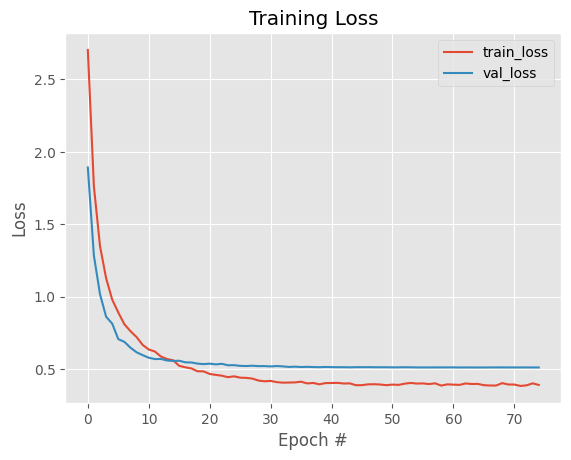

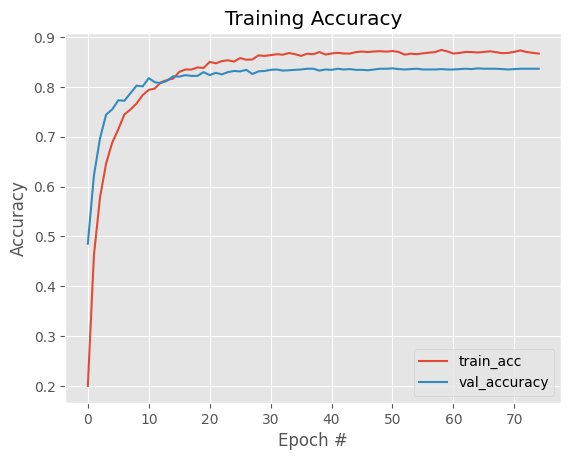

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.95      0.90      0.93        62
        down       0.87      0.77      0.82        62
       eight       0.85      0.94      0.89        62
        five       0.88      0.82      0.85        62
      follow       0.70      0.79      0.74        62
     forward       0.89      0.81      0.85        62
        four       0.79      0.81      0.80        62
          go       0.76      0.76      0.76        62
       learn       0.81      0.81      0.81        62
        left       0.88      0.92      0.90        62
        nine       0.88      0.90      0.89        62
          no       0.73      0.89      0.80        62
         off       0.82      0.82      0.82        62
          on       0.78      0.92      0.84        62
         one       0.85      0.85      0.85        62
       right       0.95      0.84      0.89        62
       seven       0.95      0.87      0.91       

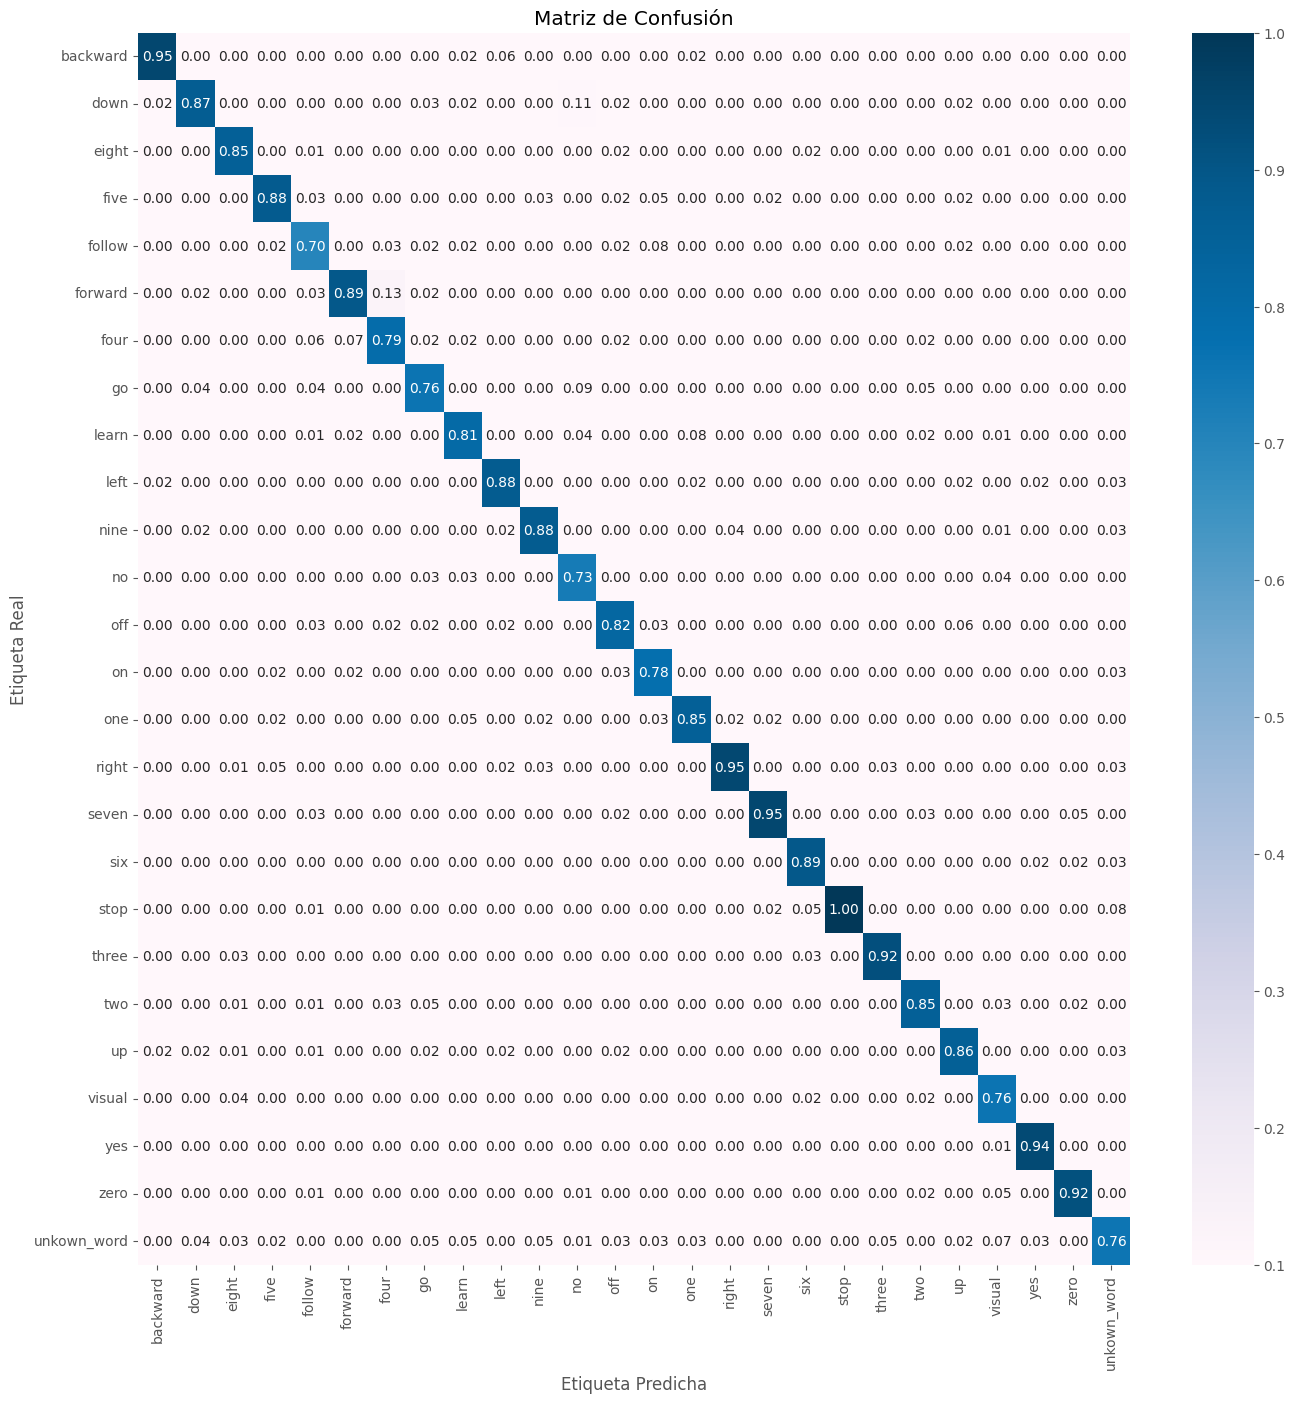

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_0_04, h_exp_a_cnn_lme_0_04, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_0_05

In [ ]:
exp_a_cnn_lme_0_05 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),

    # Capa completamente conectada
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_0_05.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_0_05.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_0_05.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_0_05 = exp_a_cnn_lme_0_05.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1086 - loss: 3.2399
Epoch 1: val_loss improved from inf to 2.59756, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.1087 - loss: 3.2389 - val_accuracy: 0.2581 - val_loss: 2.5976 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3653 - loss: 2.0917
Epoch 2: val_loss improved from 2.59756 to 1.49757, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3656 - loss: 2.0906 - val_accuracy: 0.5585 - val_loss: 1.4976 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5068 - loss: 1.5870
Epoch 3: val_loss improved from 1.49757 to 1.15626, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5075 - loss: 1.5850 - val_accuracy: 0.6438 - val_loss: 1.1563 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6166 - loss: 1.2321
Epoch 4: val_loss improved from 1.15626 to 1.01495, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6168 - loss: 1.2315 - val_accuracy: 0.6883 - val_loss: 1.0150 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6702 - loss: 1.0362
Epoch 5: val_loss improved from 1.01495 to 0.93554, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6702 - loss: 1.0361 - val_accuracy: 0.7170 - val_loss: 0.9355 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7023 - loss: 0.9277
Epoch 6: val_loss improved from 0.93554 to 0.77778, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7023 - loss: 0.9275 - val_accuracy: 0.7728 - val_loss: 0.7778 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7360 - loss: 0.8201
Epoch 7: val_loss improved from 0.77778 to 0.70533, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7361 - loss: 0.8197 - val_accuracy: 0.7940 - val_loss: 0.7053 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7617 - loss: 0.7506
Epoch 8: val_loss improved from 0.70533 to 0.62529, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7617 - loss: 0.7504 - val_accuracy: 0.8151 - val_loss: 0.6253 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7774 - loss: 0.6871
Epoch 9: val_loss did not improve from 0.62529
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7774 - loss: 0.6870 - val_accuracy: 0.8023 - val_loss: 0.6430 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8015 - loss: 0.6299
Epoch 10: val_loss improved from 0.62529 to 0.58944, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8015 - loss: 0.6297 - val_accuracy: 0.8196 - val_loss: 0.5894 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8117 - loss: 0.5923
Epoch 11: val_loss did not improve from 0.58944
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8117 - loss: 0.5922 - val_accuracy: 0.8143 - val_loss: 0.5909 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8142 - loss: 0.5622
Epoch 12: val_loss improved from 0.58944 to 0.56988, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8142 - loss: 0.5621 - val_accuracy: 0.8196 - val_loss: 0.5699 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8302 - loss: 0.5328
Epoch 13: val_loss improved from 0.56988 to 0.54769, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8302 - loss: 0.5327 - val_accuracy: 0.8332 - val_loss: 0.5477 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8367 - loss: 0.5119
Epoch 14: val_loss improved from 0.54769 to 0.53551, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8367 - loss: 0.5118 - val_accuracy: 0.8377 - val_loss: 0.5355 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8401 - loss: 0.4789
Epoch 15: val_loss did not improve from 0.53551
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8401 - loss: 0.4791 - val_accuracy: 0.8302 - val_loss: 0.5500 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8434 - loss: 0.4736
Epoch 16: val_loss improved from 0.53551 to 0.53183, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8435 - loss: 0.4733 - val_accuracy: 0.8377 - val_loss: 0.5318 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8574 - loss: 0.4417
Epoch 17: val_loss improved from 0.53183 to 0.51815, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8574 - loss: 0.4417 - val_accuracy: 0.8408 - val_loss: 0.5181 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8662 - loss: 0.4168
Epoch 18: val_loss improved from 0.51815 to 0.51426, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8661 - loss: 0.4168 - val_accuracy: 0.8513 - val_loss: 0.5143 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8655 - loss: 0.4129
Epoch 19: val_loss improved from 0.51426 to 0.50937, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8655 - loss: 0.4129 - val_accuracy: 0.8498 - val_loss: 0.5094 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8715 - loss: 0.4012
Epoch 20: val_loss did not improve from 0.50937
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8715 - loss: 0.4012 - val_accuracy: 0.8491 - val_loss: 0.5141 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8598 - loss: 0.4078
Epoch 21: val_loss improved from 0.50937 to 0.49993, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8599 - loss: 0.4076 - val_accuracy: 0.8506 - val_loss: 0.4999 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8723 - loss: 0.3986
Epoch 22: val_loss improved from 0.49993 to 0.49951, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8723 - loss: 0.3985 - val_accuracy: 0.8498 - val_loss: 0.4995 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8783 - loss: 0.3847
Epoch 23: val_loss improved from 0.49951 to 0.49433, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8783 - loss: 0.3847 - val_accuracy: 0.8543 - val_loss: 0.4943 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8784 - loss: 0.3678
Epoch 24: val_loss improved from 0.49433 to 0.48394, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8784 - loss: 0.3678 - val_accuracy: 0.8551 - val_loss: 0.4839 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8821 - loss: 0.3549
Epoch 25: val_loss did not improve from 0.48394
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8821 - loss: 0.3549 - val_accuracy: 0.8589 - val_loss: 0.4898 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8819 - loss: 0.3623
Epoch 26: val_loss did not improve from 0.48394
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8819 - loss: 0.3624 - val_accuracy: 0.8536 - val_loss: 0.4840 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8844 - loss: 0.3522 - val_accuracy: 0.8558 - val_loss: 0.4788 - learning_rate: 5.8150e-05

Epoch 29: LearningRateScheduler setting learning rate to 5.233476330273609e-05.
Epoch 29/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8908 - loss: 0.3420
Epoch 29: val_loss improved from 0.47880 to 0.47657, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8908 - loss: 0.3420 - val_accuracy: 0.8543 - val_loss: 0.4766 - learning_rate: 5.2335e-05

Epoch 30: LearningRateScheduler setting learning rate to 4.7101286972462485e-05.
Epoch 30/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8895 - loss: 0.3356
Epoch 30: val_loss improved from 0.47657 to 0.47592, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8894 - loss: 0.3357 - val_accuracy: 0.8574 - val_loss: 0.4759 - learning_rate: 4.7101e-05

Epoch 31: LearningRateScheduler setting learning rate to 4.239115827521624e-05.
Epoch 31/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8873 - loss: 0.3419
Epoch 31: val_loss improved from 0.47592 to 0.47340, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8873 - loss: 0.3419 - val_accuracy: 0.8574 - val_loss: 0.4734 - learning_rate: 4.2391e-05

Epoch 32: LearningRateScheduler setting learning rate to 3.8152042447694614e-05.
Epoch 32/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8922 - loss: 0.3261
Epoch 32: val_loss did not improve from 0.47340
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8921 - loss: 0.3261 - val_accuracy: 0.8558 - val_loss: 0.4748 - learning_rate: 3.8152e-05

Epoch 33: LearningRateScheduler setting learning rate to 3.433683820292515e-05.
Epoch 33/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8932 - loss: 0.3337
Epoch 33: val_loss improved from 0.47340 to 0.47128, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8931 - loss: 0.3337 - val_accuracy: 0.8551 - val_loss: 0.4713 - learning_rate: 3.4337e-05

Epoch 34: LearningRateScheduler setting learning rate to 3.090315438263264e-05.
Epoch 34/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8905 - loss: 0.3242
Epoch 34: val_loss did not improve from 0.47128
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8905 - loss: 0.3242 - val_accuracy: 0.8536 - val_loss: 0.4745 - learning_rate: 3.0903e-05

Epoch 35: LearningRateScheduler setting learning rate to 2.7812838944369376e-05.
Epoch 35/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8935 - loss: 0.3161
Epoch 35: val_loss did not improve from 0.47128
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8936 - loss: 0.3162 - val_accuracy: 0.8566 - val_loss: 0.4738 - learning_rate: 2.7813e-05

Epoch 36: LearningRateScheduler setting learning rate to 2.5031555049932436e-05.
Epoch 36/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8902 - loss: 0.3265 - val_accuracy: 0.8574 - val_loss: 0.4700 - learning_rate: 2.5032e-05

Epoch 37: LearningRateScheduler setting learning rate to 2.2528399544939195e-05.
Epoch 37/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8925 - loss: 0.3333
Epoch 37: val_loss did not improve from 0.46997
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8925 - loss: 0.3332 - val_accuracy: 0.8596 - val_loss: 0.4715 - learning_rate: 2.2528e-05

Epoch 38: LearningRateScheduler setting learning rate to 2.0275559590445276e-05.
Epoch 38/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8938 - loss: 0.3126
Epoch 38: val_loss did not improve from 0.46997
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8938 - loss: 0.3126 - val_accuracy: 0.8566 - val_loss: 0.4700 - learning_rate: 2.0276e-05

Epoch 39: LearningRateScheduler setting learning rate to 1.824800363140075e-05.
Epoch 39/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8942 - loss: 0.3219 - val_accuracy: 0.8581 - val_loss: 0.4683 - learning_rate: 1.8248e-05

Epoch 40: LearningRateScheduler setting learning rate to 1.6423203268260675e-05.
Epoch 40/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8964 - loss: 0.3172
Epoch 40: val_loss did not improve from 0.46828
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8964 - loss: 0.3171 - val_accuracy: 0.8574 - val_loss: 0.4698 - learning_rate: 1.6423e-05

Epoch 41: LearningRateScheduler setting learning rate to 1.4780882941434608e-05.
Epoch 41/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8958 - loss: 0.3141
Epoch 41: val_loss did not improve from 0.46828
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8958 - loss: 0.3141 - val_accuracy: 0.8574 - val_loss: 0.4695 - learning_rate: 1.4781e-05

Epoch 42: LearningRateScheduler setting learning rate to 1.3302794647291146e-05.
Epoch 42/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8980 - loss: 0.3118 - val_accuracy: 0.8596 - val_loss: 0.4673 - learning_rate: 1.3303e-05

Epoch 43: LearningRateScheduler setting learning rate to 1.1972515182562033e-05.
Epoch 43/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8927 - loss: 0.3230
Epoch 43: val_loss improved from 0.46727 to 0.46612, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8928 - loss: 0.3229 - val_accuracy: 0.8596 - val_loss: 0.4661 - learning_rate: 1.1973e-05

Epoch 44: LearningRateScheduler setting learning rate to 1.077526366430583e-05.
Epoch 44/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8933 - loss: 0.3169
Epoch 44: val_loss improved from 0.46612 to 0.46551, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8933 - loss: 0.3169 - val_accuracy: 0.8581 - val_loss: 0.4655 - learning_rate: 1.0775e-05

Epoch 45: LearningRateScheduler setting learning rate to 9.697737297875246e-06.
Epoch 45/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8949 - loss: 0.3231
Epoch 45: val_loss did not improve from 0.46551
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8949 - loss: 0.3231 - val_accuracy: 0.8574 - val_loss: 0.4677 - learning_rate: 9.6977e-06

Epoch 46: LearningRateScheduler setting learning rate to 8.727963568087722e-06.
Epoch 46/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8962 - loss: 0.3067
Epoch 46: val_loss did not improve from 0.46551
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8962 - loss: 0.3067 - val_accuracy: 0.8566 - val_loss: 0.4664 - learning_rate: 8.7280e-06

Epoch 47: LearningRateScheduler setting learning rate to 7.85516721127895e-06.
Epoch 47/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

In [ ]:
exp_a_cnn_lme_0_05.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 61, 62, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 61, 62, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 28, 29, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 12, 12, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12, 12, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 735,216 (2.80 MB)

 Trainable params: 244,922 (956.73 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 489,846 (1.87 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


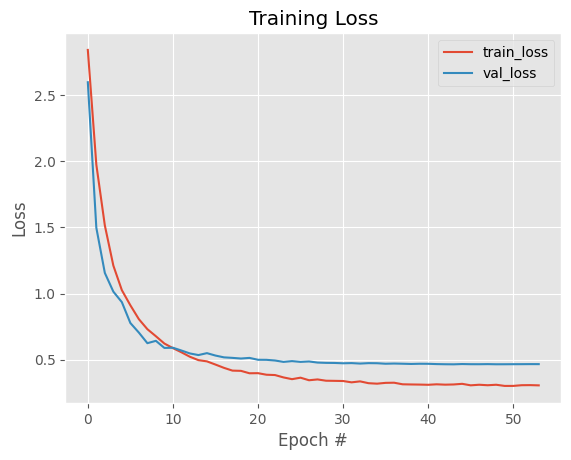

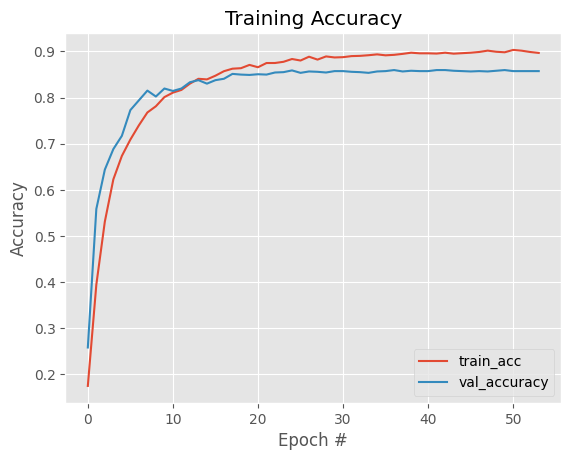

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.90      0.92      0.91        62
        down       0.91      0.81      0.85        62
       eight       0.89      0.94      0.91        62
        five       0.85      0.85      0.85        62
      follow       0.75      0.77      0.76        62
     forward       0.85      0.74      0.79        62
        four       0.75      0.85      0.80        62
          go       0.73      0.90      0.81        62
       learn       0.79      0.85      0.82        62
        left       0.98      0.94      0.96        62
        nine       0.88      0.92      0.90        62
          no       0.86      0.92      0.89        62
         off       0.92      0.87      0.89        62
          on       0.89      0.94      0.91        62
         one       0.88      0.85      0.87        62
       right       0.98      0.90      0.94        62
       seven       0.92      0.94      0.93       

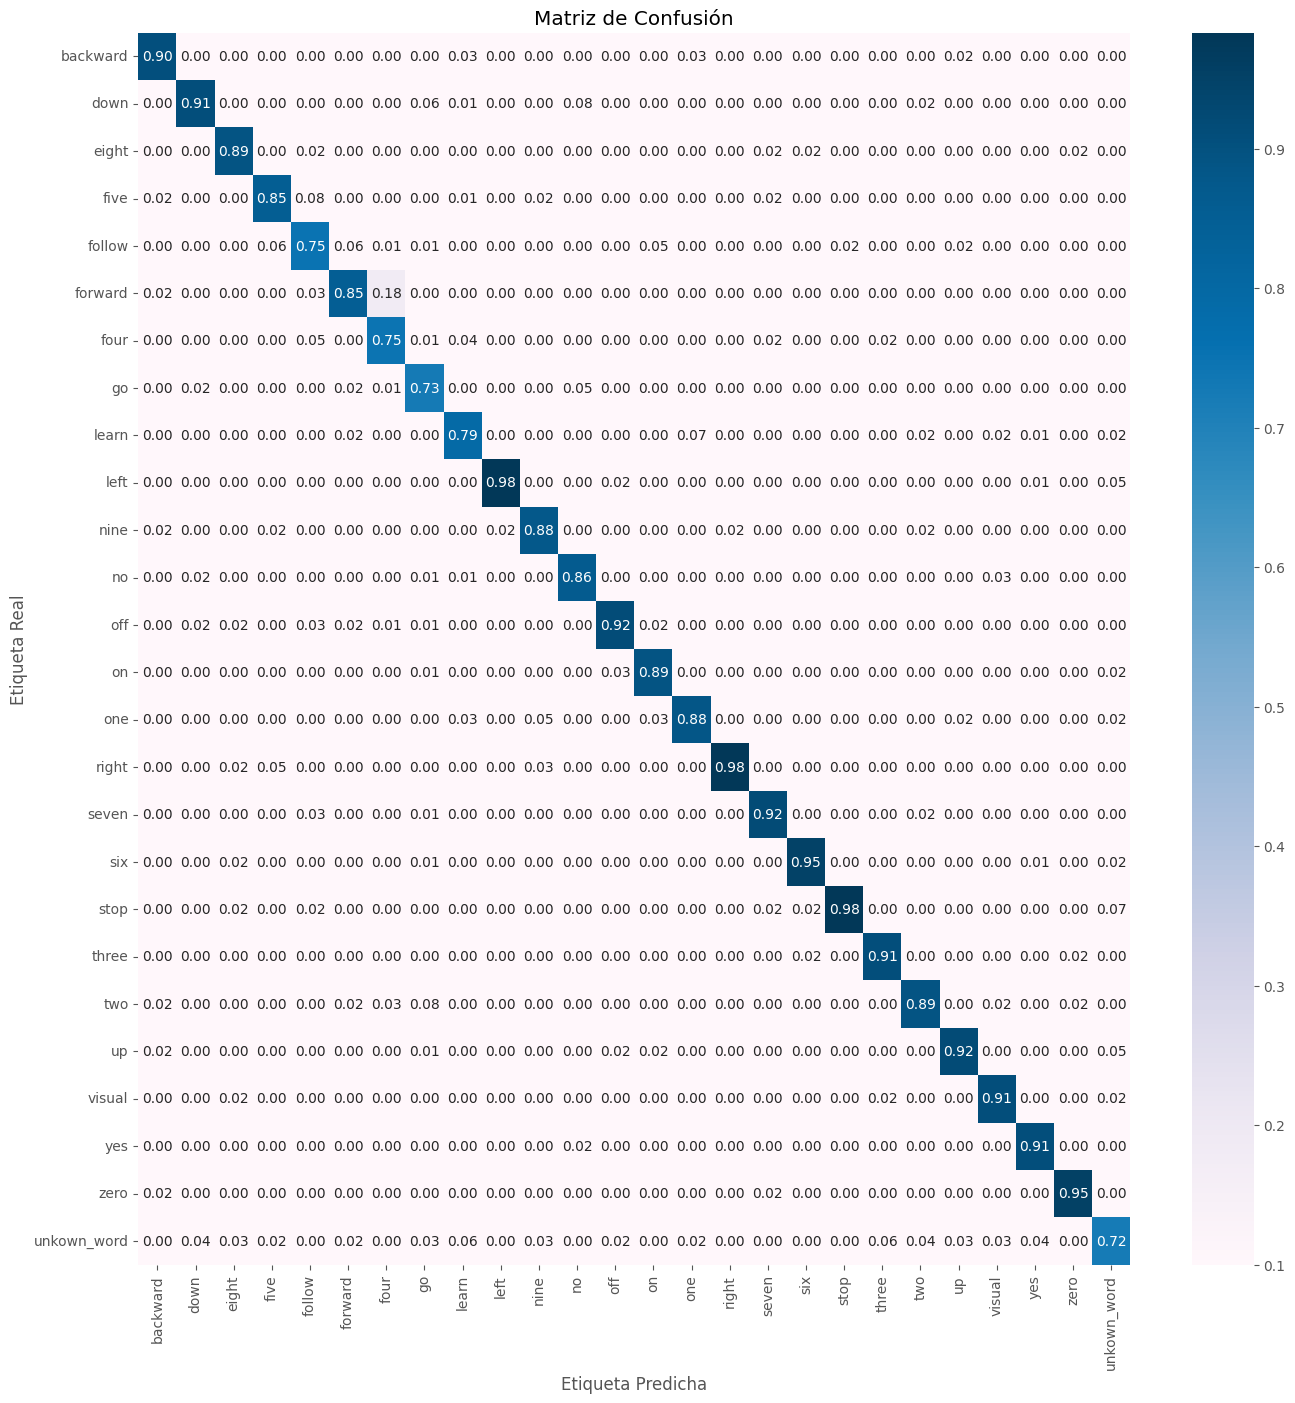

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_0_05, h_exp_a_cnn_lme_0_05, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_0_06

In [ ]:
exp_a_cnn_lme_0_06 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Flatten(),  # Aplanar para pasar a capas densas

    # Capa completamente conectada
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_0_06.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_0_06.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_0_06.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_0_06 = exp_a_cnn_lme_0_06.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1407 - loss: 3.1445
Epoch 1: val_loss improved from inf to 2.14900, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.1409 - loss: 3.1433 - val_accuracy: 0.3592 - val_loss: 2.1490 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4770 - loss: 1.7346
Epoch 2: val_loss improved from 2.14900 to 1.32361, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4773 - loss: 1.7334 - val_accuracy: 0.5925 - val_loss: 1.3236 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6348 - loss: 1.1670
Epoch 3: val_loss improved from 1.32361 to 0.89305, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6350 - loss: 1.1662 - val_accuracy: 0.7162 - val_loss: 0.8931 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7199 - loss: 0.8902
Epoch 4: val_loss improved from 0.89305 to 0.75599, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7200 - loss: 0.8898 - val_accuracy: 0.7804 - val_loss: 0.7560 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7705 - loss: 0.7341
Epoch 5: val_loss improved from 0.75599 to 0.66644, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7705 - loss: 0.7337 - val_accuracy: 0.8038 - val_loss: 0.6664 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8004 - loss: 0.6340
Epoch 6: val_loss improved from 0.66644 to 0.58306, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8005 - loss: 0.6339 - val_accuracy: 0.8264 - val_loss: 0.5831 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8282 - loss: 0.5369
Epoch 7: val_loss did not improve from 0.58306
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8282 - loss: 0.5369 - val_accuracy: 0.8287 - val_loss: 0.6035 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8459 - loss: 0.4836
Epoch 8: val_loss improved from 0.58306 to 0.54852, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8459 - loss: 0.4834 - val_accuracy: 0.8385 - val_loss: 0.5485 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8588 - loss: 0.4331
Epoch 9: val_loss did not improve from 0.54852
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8589 - loss: 0.4329 - val_accuracy: 0.8392 - val_loss: 0.5609 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8721 - loss: 0.4009
Epoch 10: val_loss did not improve from 0.54852
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8721 - loss: 0.4005 - val_accuracy: 0.8249 - val_loss: 0.5951 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8878 - loss: 0.3484 - val_accuracy: 0.8400 - val_loss: 0.5412 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8880 - loss: 0.3299
Epoch 12: val_loss improved from 0.54124 to 0.52304, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8881 - loss: 0.3298 - val_accuracy: 0.8483 - val_loss: 0.5230 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9035 - loss: 0.2901
Epoch 13: val_loss did not improve from 0.52304
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9035 - loss: 0.2900 - val_accuracy: 0.8513 - val_loss: 0.5338 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9091 - loss: 0.2723
Epoch 14: val_loss did not improve from 0.52304
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9091 - loss: 0.2723 - val_accuracy: 0.8430 - val_loss: 0.5383 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

In [ ]:
exp_a_cnn_lme_0_06.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 61, 62, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 61, 62, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 28, 29, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 28, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 12, 12, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 735,216 (2.80 MB)

 Trainable params: 244,922 (956.73 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 489,846 (1.87 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


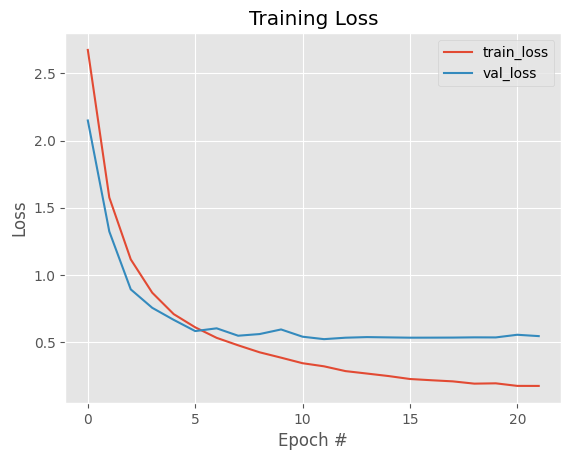

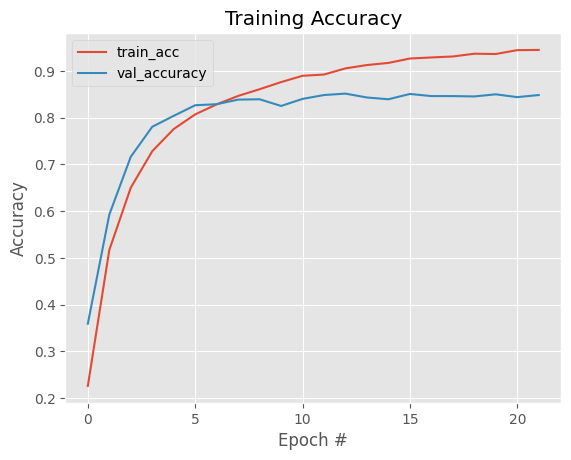

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.94      0.94      0.94        62
        down       0.91      0.81      0.85        62
       eight       0.94      0.95      0.94        62
        five       0.85      0.90      0.88        62
      follow       0.79      0.84      0.81        62
     forward       0.85      0.76      0.80        62
        four       0.77      0.82      0.80        62
          go       0.80      0.90      0.85        62
       learn       0.83      0.79      0.81        62
        left       0.90      0.85      0.88        62
        nine       0.94      0.94      0.94        62
          no       0.85      0.97      0.90        62
         off       0.89      0.81      0.85        62
          on       0.85      0.97      0.90        62
         one       0.92      0.90      0.91        62
       right       1.00      0.85      0.92        62
       seven       0.97      0.92      0.94       

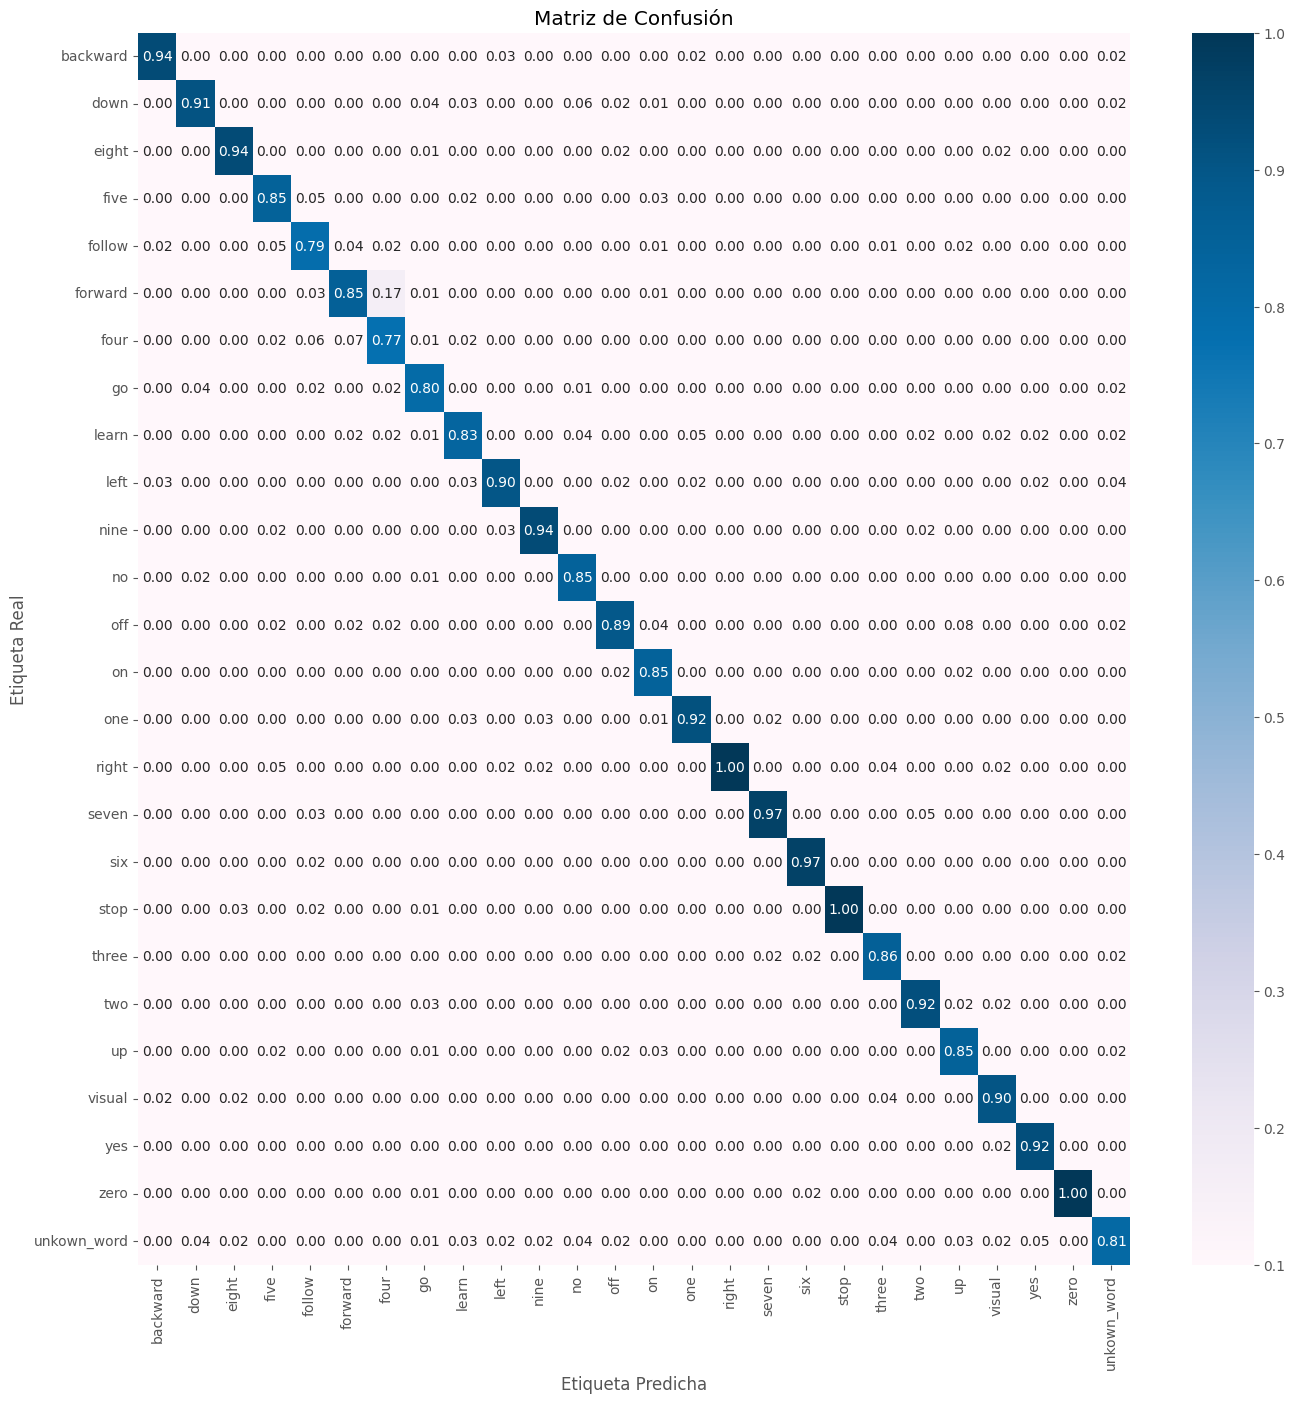

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_0_06, h_exp_a_cnn_lme_0_06, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_0_07

In [ ]:
exp_a_cnn_lme_0_07 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Flatten(),  # Aplanar para pasar a capas densas

    # Capa completamente conectada
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_0_07.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_0_07.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_0_07.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_0_07 = exp_a_cnn_lme_0_07.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0896 - loss: 3.2582
Epoch 1: val_loss improved from inf to 2.31383, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.0898 - loss: 3.2574 - val_accuracy: 0.3253 - val_loss: 2.3138 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3598 - loss: 2.0923
Epoch 2: val_loss improved from 2.31383 to 1.52532, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3603 - loss: 2.0905 - val_accuracy: 0.5358 - val_loss: 1.5253 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5270 - loss: 1.4996
Epoch 3: val_loss improved from 1.52532 to 1.06502, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5277 - loss: 1.4977 - val_accuracy: 0.6634 - val_loss: 1.0650 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6272 - loss: 1.1772
Epoch 4: val_loss did not improve from 1.06502
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6276 - loss: 1.1762 - val_accuracy: 0.6491 - val_loss: 1.0893 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6889 - loss: 1.0027
Epoch 5: val_loss improved from 1.06502 to 0.72062, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6889 - loss: 1.0026 - val_accuracy: 0.7728 - val_loss: 0.7206 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7240 - loss: 0.8802
Epoch 6: val_loss improved from 0.72062 to 0.66943, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7241 - loss: 0.8798 - val_accuracy: 0.7872 - val_loss: 0.6694 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7552 - loss: 0.7764
Epoch 7: val_loss improved from 0.66943 to 0.63720, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7553 - loss: 0.7762 - val_accuracy: 0.8030 - val_loss: 0.6372 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7722 - loss: 0.7056
Epoch 8: val_loss improved from 0.63720 to 0.58735, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7722 - loss: 0.7055 - val_accuracy: 0.8083 - val_loss: 0.5873 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7934 - loss: 0.6374
Epoch 9: val_loss improved from 0.58735 to 0.56563, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7935 - loss: 0.6373 - val_accuracy: 0.8302 - val_loss: 0.5656 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8094 - loss: 0.5866
Epoch 10: val_loss improved from 0.56563 to 0.54603, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8094 - loss: 0.5866 - val_accuracy: 0.8294 - val_loss: 0.5460 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8198 - loss: 0.5511
Epoch 11: val_loss improved from 0.54603 to 0.53737, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8198 - loss: 0.5510 - val_accuracy: 0.8309 - val_loss: 0.5374 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8347 - loss: 0.5113
Epoch 12: val_loss improved from 0.53737 to 0.50680, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8347 - loss: 0.5111 - val_accuracy: 0.8453 - val_loss: 0.5068 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8522 - loss: 0.4600
Epoch 13: val_loss did not improve from 0.50680
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8522 - loss: 0.4600 - val_accuracy: 0.8468 - val_loss: 0.5207 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8576 - loss: 0.4470
Epoch 14: val_loss did not improve from 0.50680
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8576 - loss: 0.4470 - val_accuracy: 0.8355 - val_loss: 0.5512 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8622 - loss: 0.4183 - val_accuracy: 0.8551 - val_loss: 0.5025 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8789 - loss: 0.3720
Epoch 17: val_loss improved from 0.50250 to 0.50034, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8789 - loss: 0.3720 - val_accuracy: 0.8506 - val_loss: 0.5003 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8865 - loss: 0.3609
Epoch 18: val_loss did not improve from 0.50034
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8864 - loss: 0.3609 - val_accuracy: 0.8521 - val_loss: 0.5038 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8856 - loss: 0.3539
Epoch 19: val_loss did not improve from 0.50034
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8856 - loss: 0.3539 - val_accuracy: 0.8430 - val_loss: 0.5068 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8909 - loss: 0.3316 - val_accuracy: 0.8521 - val_loss: 0.4923 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8992 - loss: 0.3178
Epoch 21: val_loss did not improve from 0.49226
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8992 - loss: 0.3178 - val_accuracy: 0.8574 - val_loss: 0.4976 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8971 - loss: 0.3079
Epoch 22: val_loss improved from 0.49226 to 0.48858, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8971 - loss: 0.3080 - val_accuracy: 0.8581 - val_loss: 0.4886 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8988 - loss: 0.3131
Epoch 23: val_loss did not improve from 0.48858
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8988 - loss: 0.3131 - val_accuracy: 0.8626 - val_loss: 0.4942 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9067 - loss: 0.3014
Epoch 24: val_loss improved from 0.48858 to 0.48282, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9066 - loss: 0.3013 - val_accuracy: 0.8574 - val_loss: 0.4828 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9014 - loss: 0.2964
Epoch 25: val_loss improved from 0.48282 to 0.48146, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9014 - loss: 0.2964 - val_accuracy: 0.8574 - val_loss: 0.4815 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9054 - loss: 0.2920
Epoch 26: val_loss did not improve from 0.48146
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9054 - loss: 0.2919 - val_accuracy: 0.8581 - val_loss: 0.4834 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9118 - loss: 0.2727
Epoch 27: val_loss did not improve from 0.48146
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9118 - loss: 0.2727 - val_accuracy: 0.8551 - val_loss: 0.4880 - learning_rate: 6.4611e-05

Epoch 28: LearningRateScheduler setting learning rate to 5.8149737003040094e-05.
Epoch 28/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9176 - loss: 0.2517 - val_accuracy: 0.8589 - val_loss: 0.4798 - learning_rate: 3.0903e-05

Epoch 35: LearningRateScheduler setting learning rate to 2.7812838944369376e-05.
Epoch 35/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9198 - loss: 0.2486
Epoch 35: val_loss did not improve from 0.47980
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9198 - loss: 0.2487 - val_accuracy: 0.8589 - val_loss: 0.4826 - learning_rate: 2.7813e-05

Epoch 36: LearningRateScheduler setting learning rate to 2.5031555049932436e-05.
Epoch 36/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9183 - loss: 0.2455
Epoch 36: val_loss did not improve from 0.47980
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9182 - loss: 0.2456 - val_accuracy: 0.8589 - val_loss: 0.4891 - learning_rate: 2.5032e-05

Epoch 37: LearningRateScheduler setting learning rate to 2.2528399544939195e-05.
Epoch 37/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

In [ ]:
exp_a_cnn_lme_0_07.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 61, 62, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 61, 62, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 28, 29, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 28, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 12, 12, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 12, 12, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 754,992 (2.88 MB)

 Trainable params: 251,514 (982.48 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 503,030 (1.92 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


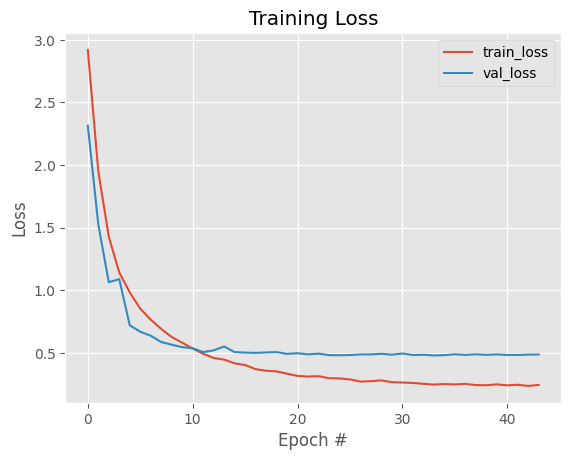

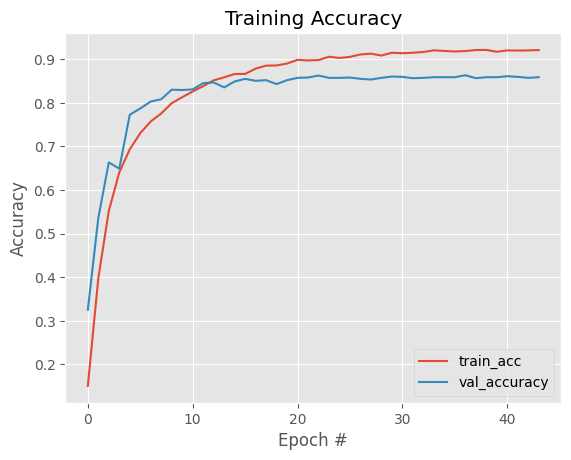

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.89      0.95      0.92        62
        down       0.87      0.77      0.82        62
       eight       0.92      0.92      0.92        62
        five       0.89      0.87      0.88        62
      follow       0.80      0.85      0.83        62
     forward       0.86      0.79      0.82        62
        four       0.80      0.85      0.83        62
          go       0.82      0.85      0.83        62
       learn       0.84      0.79      0.82        62
        left       0.92      0.89      0.90        62
        nine       0.88      0.90      0.89        62
          no       0.85      0.89      0.87        62
         off       0.89      0.87      0.88        62
          on       0.83      0.92      0.87        62
         one       0.86      0.89      0.87        62
       right       0.97      0.90      0.93        62
       seven       0.98      0.95      0.97       

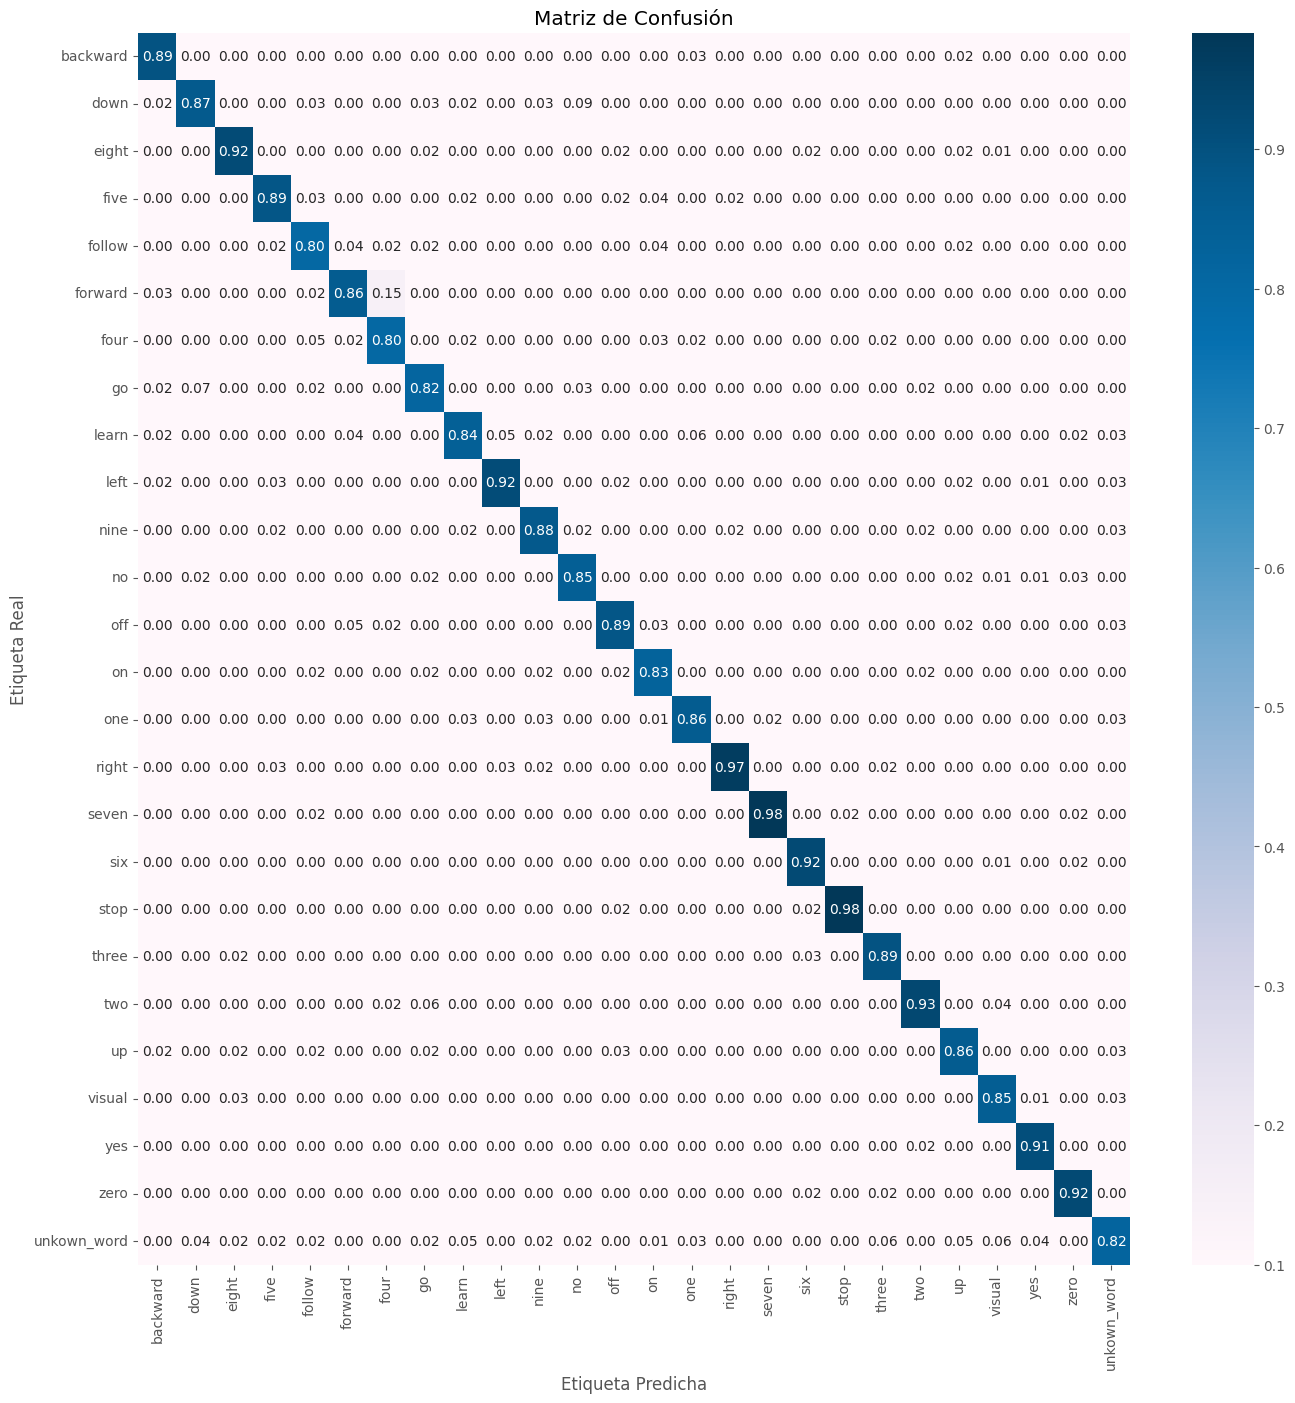

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_0_07, h_exp_a_cnn_lme_0_07, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_0_08

In [ ]:
exp_a_cnn_lme_0_08 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Flatten(),  # Aplanar para pasar a capas densas

    # Capa completamente conectada
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_0_08.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_0_08.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_0_08.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_0_08 = exp_a_cnn_lme_0_08.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1466 - loss: 2.9941
Epoch 1: val_loss improved from inf to 2.38601, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.1468 - loss: 2.9929 - val_accuracy: 0.2883 - val_loss: 2.3860 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5193 - loss: 1.5381
Epoch 2: val_loss improved from 2.38601 to 1.03962, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5200 - loss: 1.5359 - val_accuracy: 0.6747 - val_loss: 1.0396 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6659 - loss: 1.0335
Epoch 3: val_loss improved from 1.03962 to 0.91738, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6666 - loss: 1.0317 - val_accuracy: 0.7170 - val_loss: 0.9174 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7439 - loss: 0.8074
Epoch 4: val_loss improved from 0.91738 to 0.80646, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7441 - loss: 0.8066 - val_accuracy: 0.7600 - val_loss: 0.8065 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7859 - loss: 0.6468
Epoch 5: val_loss improved from 0.80646 to 0.70468, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7860 - loss: 0.6466 - val_accuracy: 0.7887 - val_loss: 0.7047 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8275 - loss: 0.5531
Epoch 6: val_loss improved from 0.70468 to 0.66096, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8275 - loss: 0.5530 - val_accuracy: 0.8045 - val_loss: 0.6610 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8365 - loss: 0.4849
Epoch 7: val_loss improved from 0.66096 to 0.62597, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8367 - loss: 0.4846 - val_accuracy: 0.8053 - val_loss: 0.6260 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8664 - loss: 0.4171
Epoch 8: val_loss improved from 0.62597 to 0.60602, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8664 - loss: 0.4169 - val_accuracy: 0.8174 - val_loss: 0.6060 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8809 - loss: 0.3662
Epoch 9: val_loss improved from 0.60602 to 0.57268, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8810 - loss: 0.3662 - val_accuracy: 0.8325 - val_loss: 0.5727 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8946 - loss: 0.3323
Epoch 10: val_loss did not improve from 0.57268
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8946 - loss: 0.3323 - val_accuracy: 0.8196 - val_loss: 0.6295 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9012 - loss: 0.2961
Epoch 11: val_loss did not improve from 0.57268
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9012 - loss: 0.2960 - val_accuracy: 0.8279 - val_loss: 0.5839 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9108 - loss: 0.2712 - val_accuracy: 0.8347 - val_loss: 0.5612 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9172 - loss: 0.2401
Epoch 13: val_loss did not improve from 0.56118
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9172 - loss: 0.2401 - val_accuracy: 0.8408 - val_loss: 0.5634 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9199 - loss: 0.2281
Epoch 14: val_loss improved from 0.56118 to 0.55266, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9201 - loss: 0.2280 - val_accuracy: 0.8468 - val_loss: 0.5527 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9392 - loss: 0.1943
Epoch 15: val_loss did not improve from 0.55266
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9392 - loss: 0.1943 - val_accuracy: 0.8377 - val_loss: 0.6033 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9387 - loss: 0.1871
Epoch 16: val_loss did not improve from 0.55266
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9388 - loss: 0.1870 - val_accuracy: 0.8453 - val_loss: 0.5677 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

In [ ]:
exp_a_cnn_lme_0_08.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 61, 62, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 61, 62, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 28, 29, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 28, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 12, 12, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 12, 12, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 754,992 (2.88 MB)

 Trainable params: 251,514 (982.48 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 503,030 (1.92 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


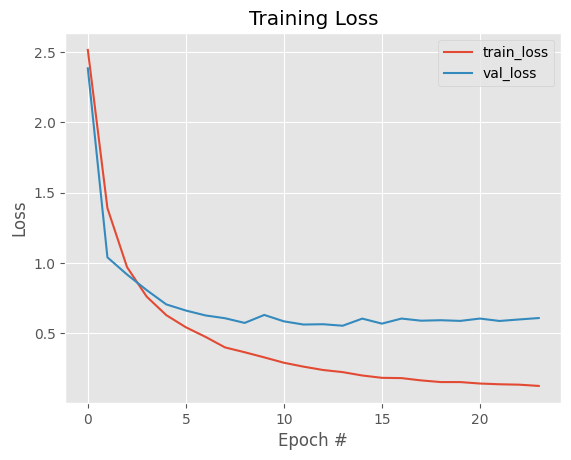

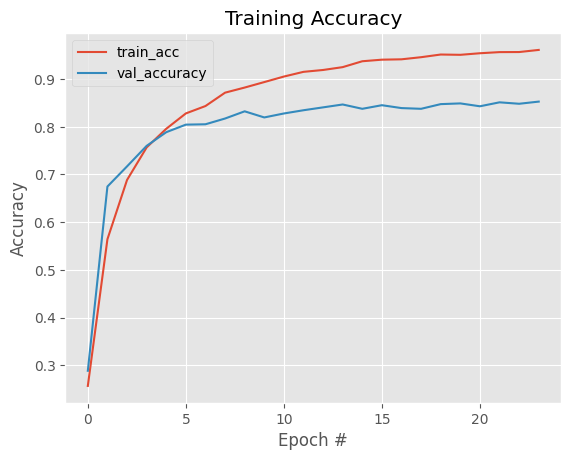

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.92      0.94      0.93        62
        down       0.85      0.81      0.83        62
       eight       0.90      0.90      0.90        62
        five       0.86      0.89      0.87        62
      follow       0.73      0.76      0.75        62
     forward       0.76      0.77      0.77        62
        four       0.74      0.79      0.77        62
          go       0.76      0.90      0.82        62
       learn       0.75      0.79      0.77        62
        left       0.98      0.89      0.93        62
        nine       0.90      0.90      0.90        62
          no       0.88      0.84      0.86        62
         off       0.93      0.85      0.89        62
          on       0.85      0.90      0.88        62
         one       0.92      0.89      0.90        62
       right       0.96      0.87      0.92        62
       seven       0.89      0.94      0.91       

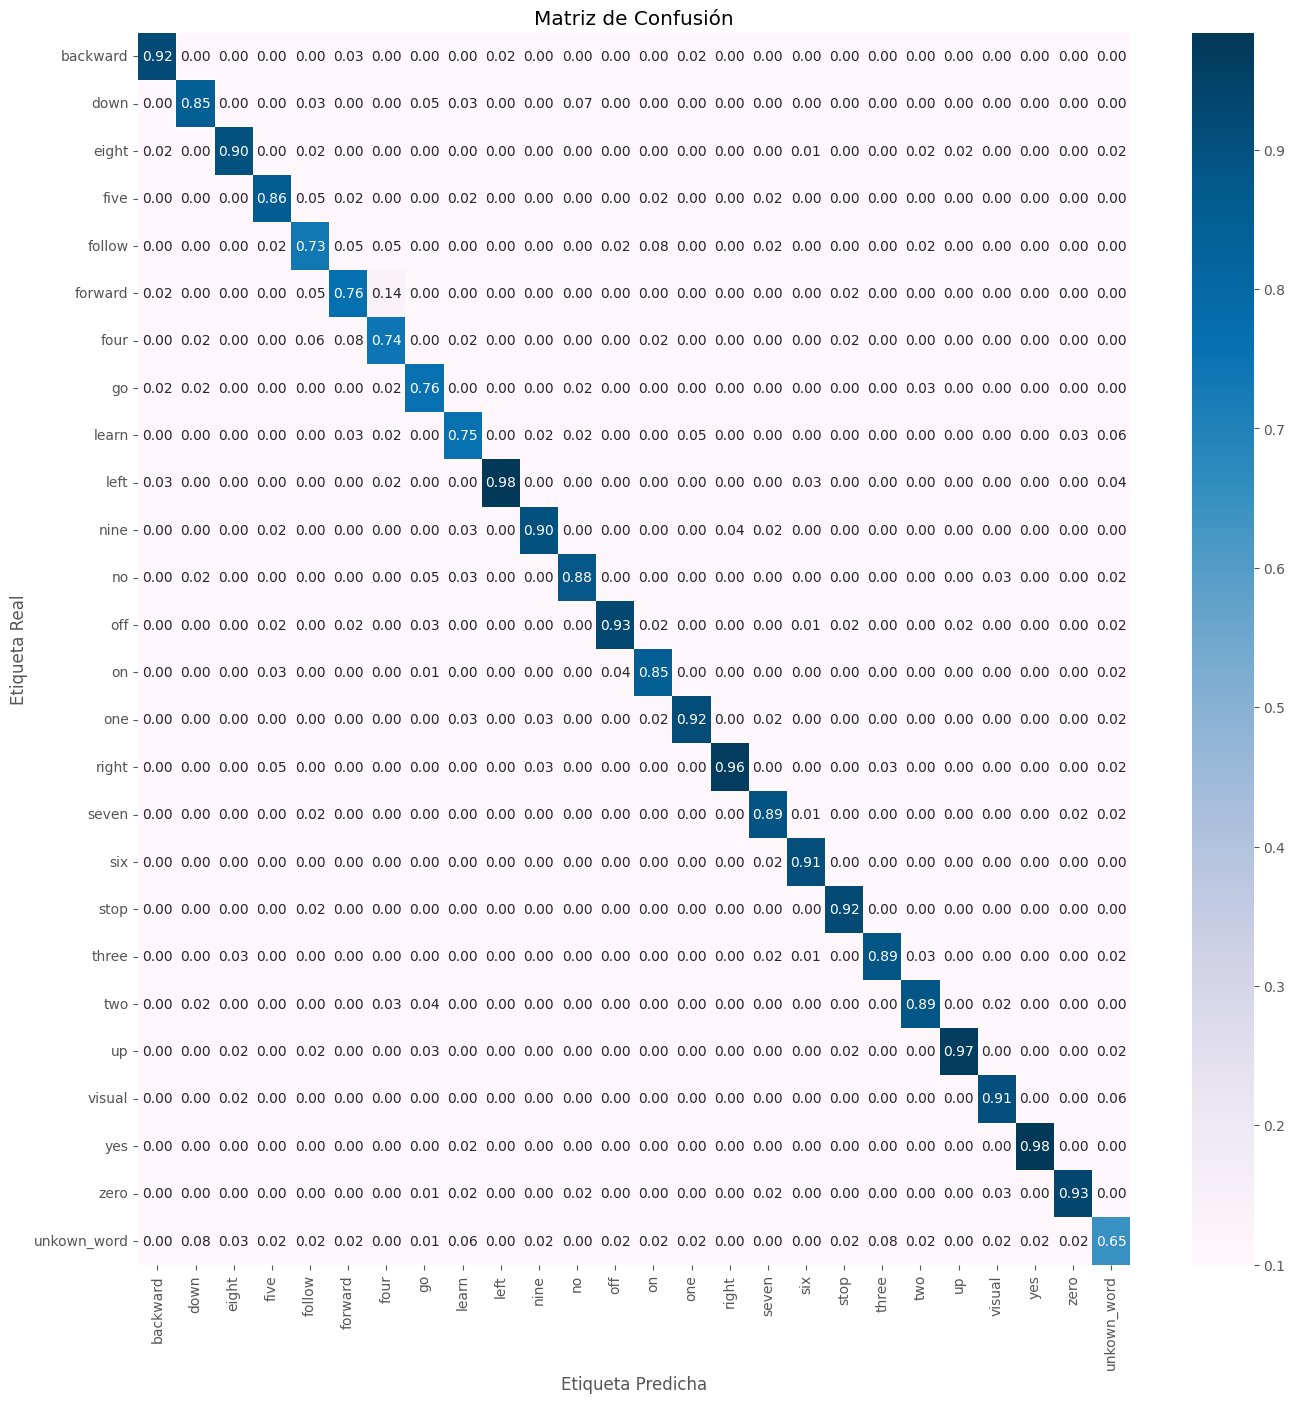

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_0_08, h_exp_a_cnn_lme_0_08, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_0_09

In [ ]:
exp_a_cnn_lme_0_09 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Flatten(),  # Aplanar para pasar a capas densas

    # Capa completamente conectada
    Dense(128, activation='relu'),
    Dropout(0.1),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_0_09.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_0_09.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_0_09.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_0_09 = exp_a_cnn_lme_0_09.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2014 - loss: 2.8899
Epoch 1: val_loss improved from inf to 2.07992, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.2017 - loss: 2.8884 - val_accuracy: 0.3811 - val_loss: 2.0799 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6182 - loss: 1.2398
Epoch 2: val_loss improved from 2.07992 to 0.83298, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6192 - loss: 1.2363 - val_accuracy: 0.7449 - val_loss: 0.8330 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7434 - loss: 0.8088
Epoch 3: val_loss improved from 0.83298 to 0.71188, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7437 - loss: 0.8080 - val_accuracy: 0.7789 - val_loss: 0.7119 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8060 - loss: 0.6090
Epoch 4: val_loss improved from 0.71188 to 0.69346, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8061 - loss: 0.6086 - val_accuracy: 0.7925 - val_loss: 0.6935 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8478 - loss: 0.4832
Epoch 5: val_loss improved from 0.69346 to 0.62449, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8481 - loss: 0.4823 - val_accuracy: 0.8106 - val_loss: 0.6245 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8705 - loss: 0.4003
Epoch 6: val_loss improved from 0.62449 to 0.61867, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8705 - loss: 0.4002 - val_accuracy: 0.8106 - val_loss: 0.6187 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8952 - loss: 0.3260
Epoch 7: val_loss improved from 0.61867 to 0.55190, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8953 - loss: 0.3256 - val_accuracy: 0.8347 - val_loss: 0.5519 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9104 - loss: 0.2763
Epoch 8: val_loss did not improve from 0.55190
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9105 - loss: 0.2760 - val_accuracy: 0.8204 - val_loss: 0.5694 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9242 - loss: 0.2313
Epoch 9: val_loss improved from 0.55190 to 0.51538, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9242 - loss: 0.2312 - val_accuracy: 0.8475 - val_loss: 0.5154 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9325 - loss: 0.2109
Epoch 10: val_loss did not improve from 0.51538
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9327 - loss: 0.2104 - val_accuracy: 0.8453 - val_loss: 0.5259 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9470 - loss: 0.1753
Epoch 11: val_loss did not improve from 0.51538
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9470 - loss: 0.1753 - val_accuracy: 0.8491 - val_loss: 0.5310 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

In [ ]:
exp_a_cnn_lme_0_09.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 61, 62, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 61, 62, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 28, 29, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 28, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 12, 12, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 12, 12, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 735,216 (2.80 MB)

 Trainable params: 244,922 (956.73 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 489,846 (1.87 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


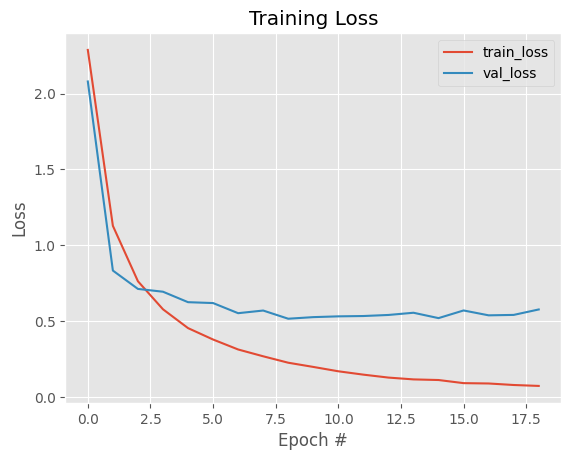

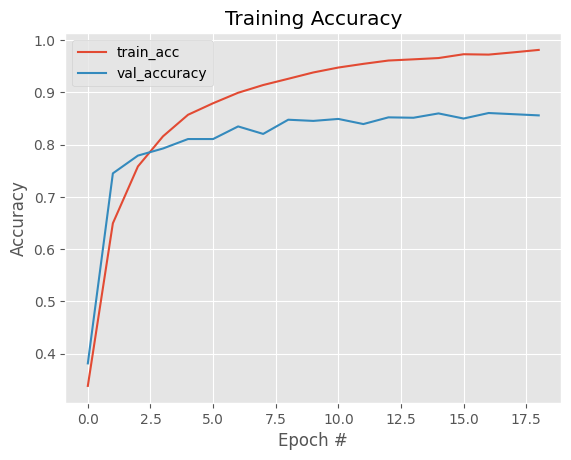

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.95      0.95      0.95        62
        down       0.86      0.81      0.83        62
       eight       0.93      0.90      0.92        62
        five       0.85      0.89      0.87        62
      follow       0.83      0.84      0.83        62
     forward       0.80      0.76      0.78        62
        four       0.75      0.82      0.78        62
          go       0.69      0.89      0.77        62
       learn       0.80      0.71      0.75        62
        left       0.96      0.87      0.92        62
        nine       0.98      0.92      0.95        62
          no       0.84      0.92      0.88        62
         off       0.89      0.90      0.90        62
          on       0.84      0.90      0.87        62
         one       0.96      0.89      0.92        62
       right       1.00      0.89      0.94        62
       seven       0.89      0.89      0.89       

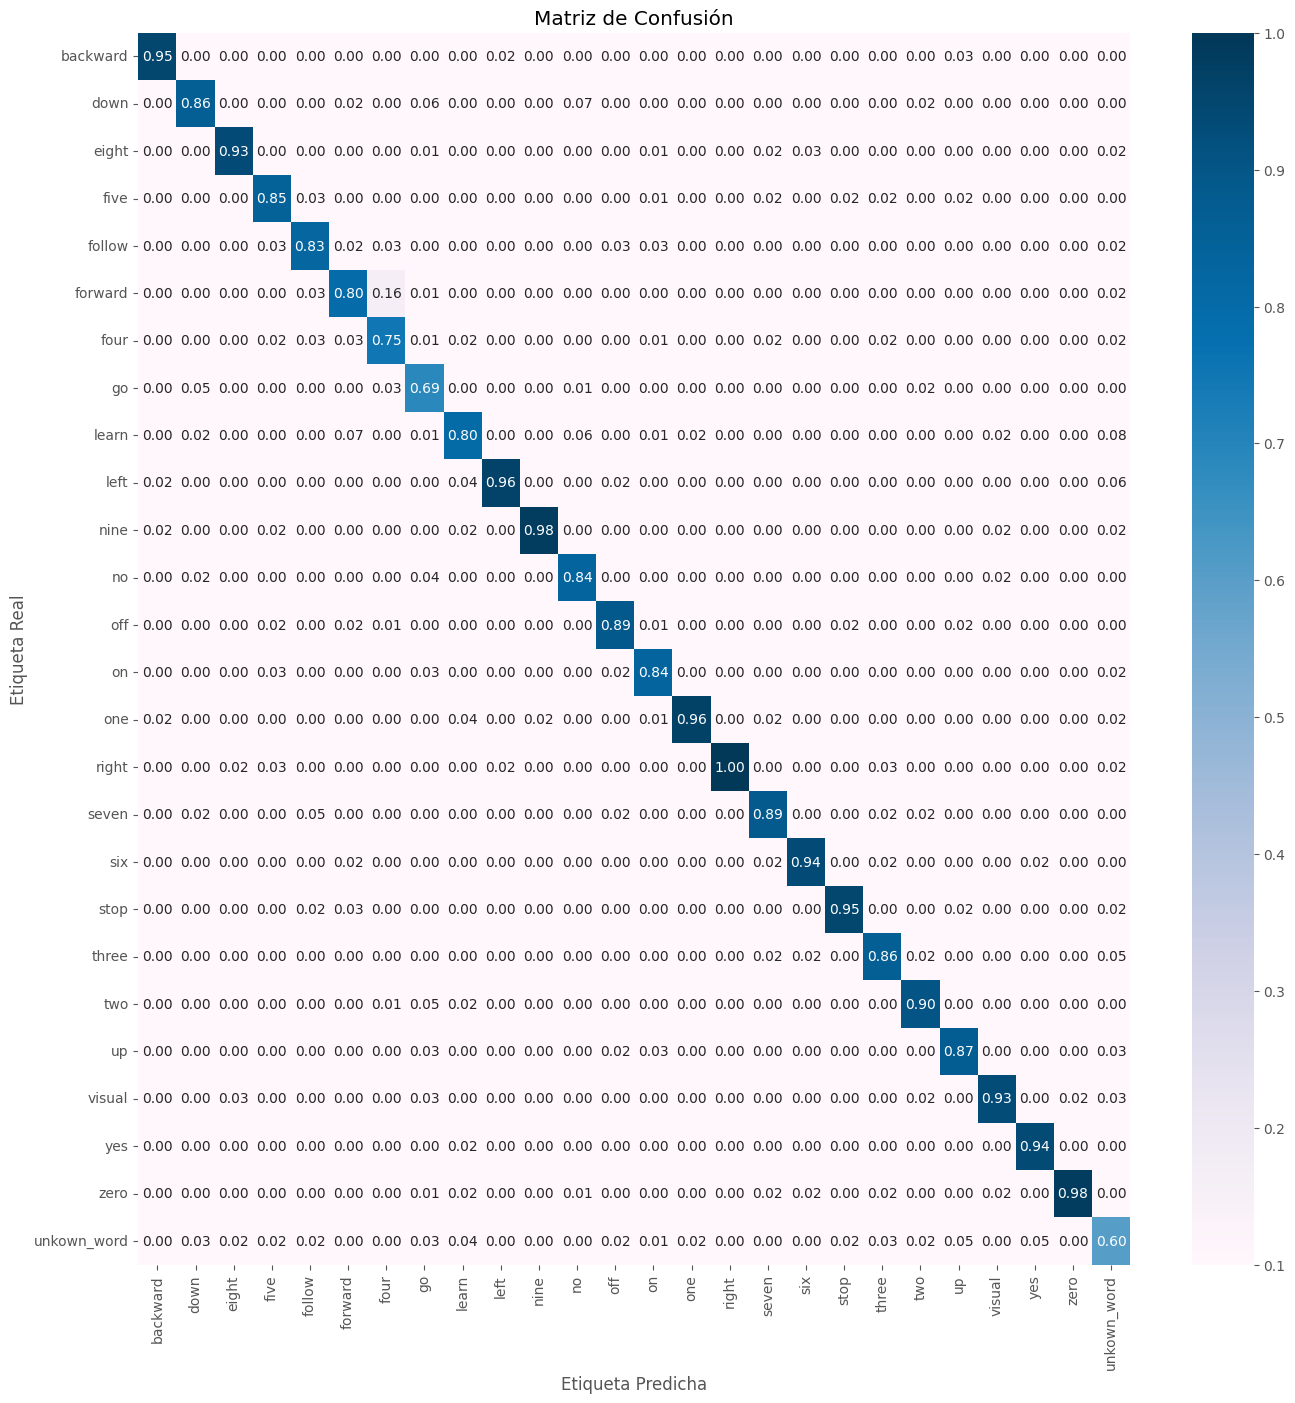

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_0_09, h_exp_a_cnn_lme_0_09, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_lme_0_10

Sin normalizar los datos (no se va a tener en cuenta este experimento)

In [ ]:
exp_a_cnn_lme_0_10 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Flatten(),  # Aplanar para pasar a capas densas

    # Capa completamente conectada
    Dense(128, activation='relu'),
    Dropout(0.1),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_lme_0_10.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_lme_0_10.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_lme_0_10.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_lme_0_10 = exp_a_cnn_lme_0_10.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1979 - loss: 2.8923
Epoch 1: val_loss improved from inf to 2.09430, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_10.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.1982 - loss: 2.8909 - val_accuracy: 0.3721 - val_loss: 2.0943 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6086 - loss: 1.2637
Epoch 2: val_loss improved from 2.09430 to 0.98122, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_10.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6088 - loss: 1.2629 - val_accuracy: 0.7125 - val_loss: 0.9812 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7328 - loss: 0.8369
Epoch 3: val_loss improved from 0.98122 to 0.93782, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_10.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7330 - loss: 0.8363 - val_accuracy: 0.7155 - val_loss: 0.9378 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8035 - loss: 0.6230
Epoch 4: val_loss improved from 0.93782 to 0.69247, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_10.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8036 - loss: 0.6223 - val_accuracy: 0.7879 - val_loss: 0.6925 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8320 - loss: 0.5131
Epoch 5: val_loss improved from 0.69247 to 0.63163, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_10.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8321 - loss: 0.5127 - val_accuracy: 0.8166 - val_loss: 0.6316 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8663 - loss: 0.4192
Epoch 6: val_loss improved from 0.63163 to 0.63148, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_10.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8664 - loss: 0.4188 - val_accuracy: 0.8121 - val_loss: 0.6315 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8939 - loss: 0.3352
Epoch 7: val_loss did not improve from 0.63148
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8939 - loss: 0.3351 - val_accuracy: 0.7940 - val_loss: 0.6617 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9084 - loss: 0.2861
Epoch 8: val_loss improved from 0.63148 to 0.60386, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_10.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9085 - loss: 0.2856 - val_accuracy: 0.8287 - val_loss: 0.6039 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9183 - loss: 0.2489
Epoch 9: val_loss did not improve from 0.60386
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9183 - loss: 0.2488 - val_accuracy: 0.8340 - val_loss: 0.6481 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9340 - loss: 0.2057
Epoch 10: val_loss improved from 0.60386 to 0.56774, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_10.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9340 - loss: 0.2056 - val_accuracy: 0.8438 - val_loss: 0.5677 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9419 - loss: 0.1820
Epoch 11: val_loss did not improve from 0.56774
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9420 - loss: 0.1818 - val_accuracy: 0.8377 - val_loss: 0.5860 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9473 - loss: 0.1567
Epoch 12: val_loss improved from 0.56774 to 0.56488, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_10.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9475 - loss: 0.1565 - val_accuracy: 0.8498 - val_loss: 0.5649 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9583 - loss: 0.1406
Epoch 13: val_loss improved from 0.56488 to 0.55757, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_lme_0_10.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9583 - loss: 0.1405 - val_accuracy: 0.8430 - val_loss: 0.5576 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9626 - loss: 0.1212
Epoch 14: val_loss did not improve from 0.55757
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9626 - loss: 0.1210 - val_accuracy: 0.8415 - val_loss: 0.5900 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9648 - loss: 0.1114
Epoch 15: val_loss did not improve from 0.55757
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9649 - loss: 0.1112 - val_accuracy: 0.8468 - val_loss: 0.5875 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

In [ ]:
exp_a_cnn_lme_0_10.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 61, 62, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 61, 62, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 30, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 28, 29, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 28, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 12, 12, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 12, 12, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 735,216 (2.80 MB)

 Trainable params: 244,922 (956.73 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 489,846 (1.87 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


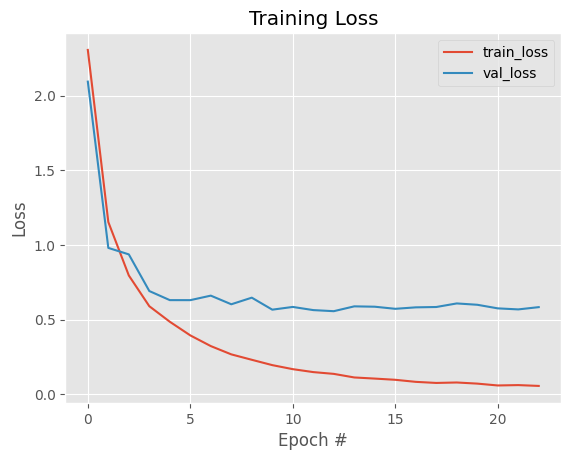

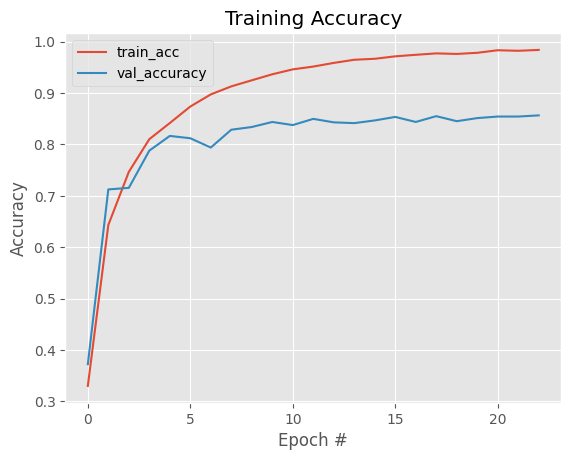

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.93      0.90      0.92        62
        down       0.93      0.85      0.89        62
       eight       0.89      0.92      0.90        62
        five       0.90      0.85      0.88        62
      follow       0.79      0.84      0.81        62
     forward       0.83      0.69      0.75        62
        four       0.74      0.79      0.77        62
          go       0.75      0.85      0.80        62
       learn       0.84      0.79      0.82        62
        left       0.95      0.92      0.93        62
        nine       0.94      0.94      0.94        62
          no       0.78      0.90      0.84        62
         off       0.85      0.85      0.85        62
          on       0.87      0.94      0.90        62
         one       0.92      0.90      0.91        62
       right       0.95      0.89      0.92        62
       seven       0.92      0.94      0.93       

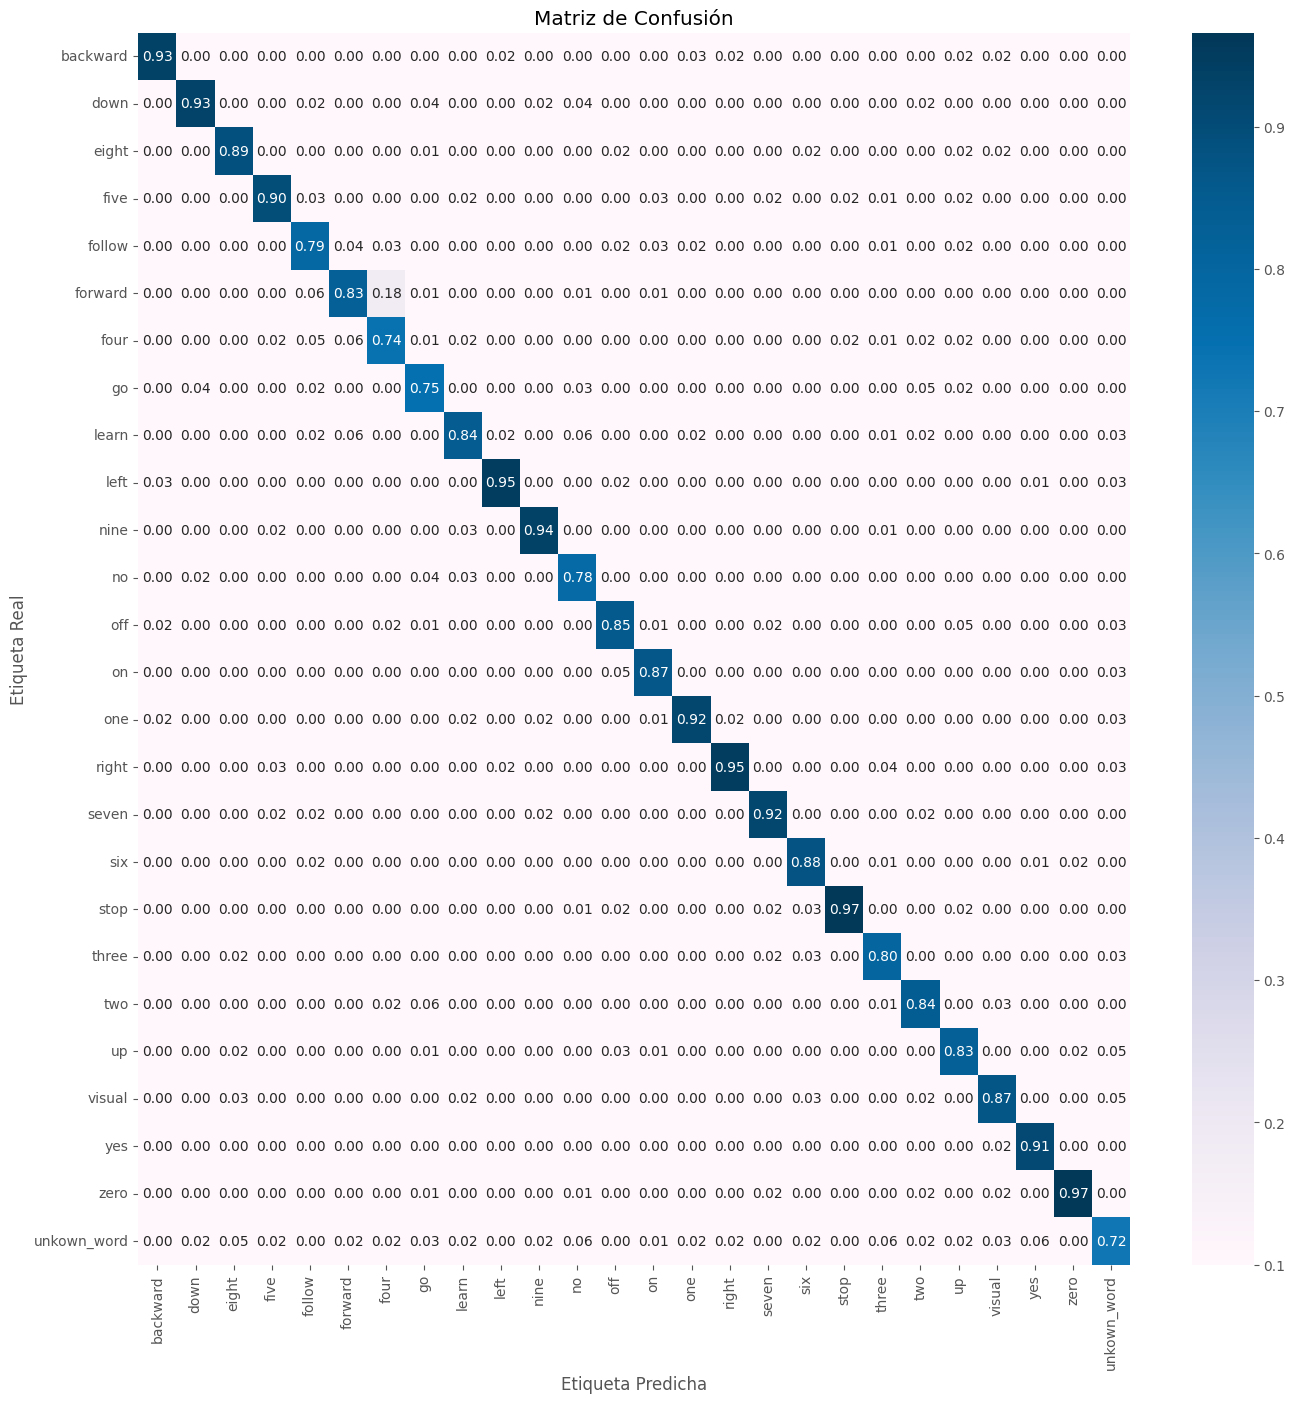

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_lme_0_10, h_exp_a_cnn_lme_0_10, x_test, y_test, batch_size, classes)
mis.show_all()